# Machine Learning - Project [2024 - 2025]

- **Nikos Mitsakis**: 3210122

- **Maria Schoinaki**: 3210191

- Set Up Colab Environment

In [11]:
# Execute this to setup the environment with the required packages in Google Colab (used to develop the MLP)
#%pip install numpy pandas matplotlib seaborn scikit-learn tqdm statsmodels scipy transformers datasets nltk gensim torch torchtext torchinfo

- Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
import scipy as sp
import random
import re

## The Task

### Multi-class Text Classification
Our task is to classify news articles in one of the 4 following topics:
- World (label = 0)
- Sports (label = 1)
- Business (label = 2)
- Sci/Tech (label = 3)

## The Dataset

In [57]:
from datasets import load_dataset
# Load the AG News dataset
dataset = load_dataset("fancyzhx/ag_news")

In [58]:
print(dataset.keys())

dict_keys(['train', 'test'])


In [59]:
# Access the training data
train_data = dataset['train']

# Display the first example
print(train_data[0])

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}


In [60]:
# Access the test data
test_data = dataset['test']

# Display the first example
print(test_data[0])

{'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.", 'label': 2}


In [61]:
# Convert to Pandas DataFrames
train_df = train_data.to_pandas()
test_df = test_data.to_pandas()

In [62]:
# Define the category mapping
category_mapping = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

# Apply the mapping to the 'label' column
train_df['Category'] = train_df['label'].map(category_mapping)
test_df['Category'] = test_df['label'].map(category_mapping)

## Plots & Data Statistics

In [63]:
def plot_distribution_of_categories(df, label="Training"):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='Category', hue='Category', palette='viridis', legend=False)
    plt.title(f'Distribution of Categories in the {label} Dataset')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.show()

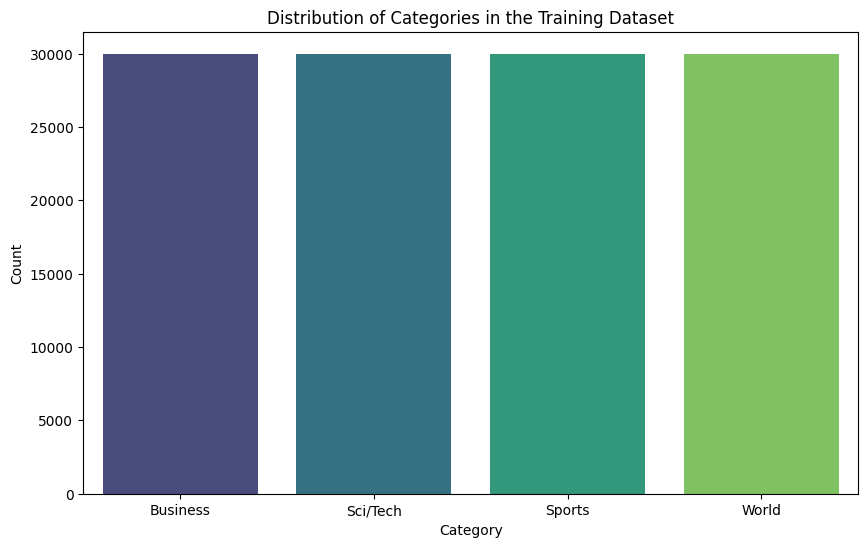

In [64]:
# Plot for the training dataset
plot_distribution_of_categories(train_df)

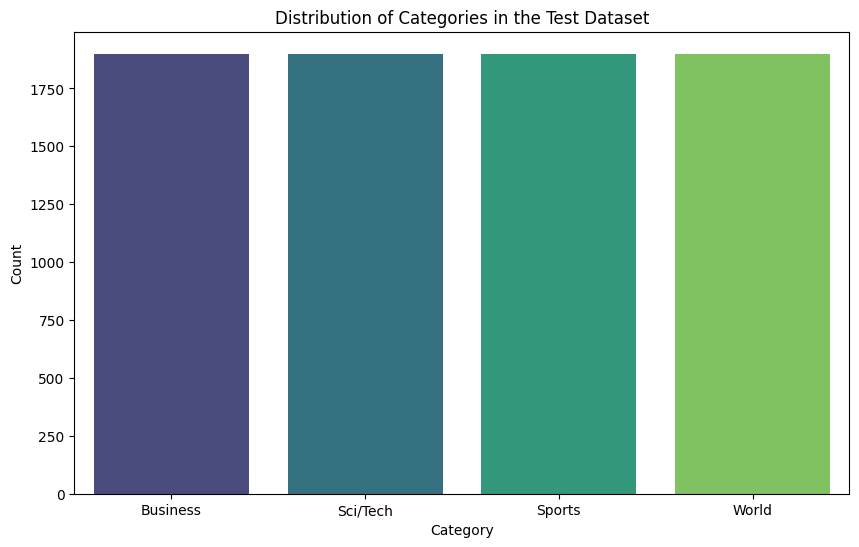

In [65]:
# Plot for the test dataset
plot_distribution_of_categories(test_df, "Test")

In [66]:
def plot_char_count_distribution_by_category(df, label="Training"):
    # Calculate text lengths in characters for the dataset
    df['text_length_char'] = df['text'].str.len()

    # Plot character count distribution by category for the dataset
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df, x='Category', y='text_length_char', hue='Category', palette='viridis', legend=False)
    plt.title(f'Distribution of Text Length (Character Count) by Category in {label} Dataset')
    plt.xlabel('Category')
    plt.ylabel('Text Length (Characters)')
    plt.show()

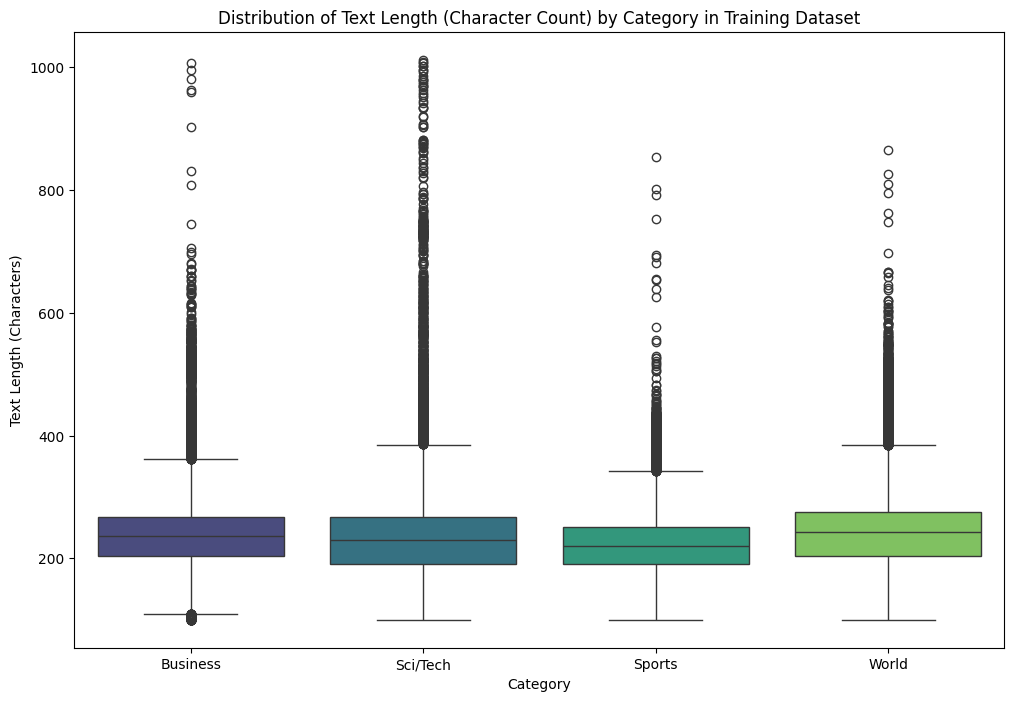

In [67]:
# Plot character count distribution by category for the training dataset
plot_char_count_distribution_by_category(train_df)

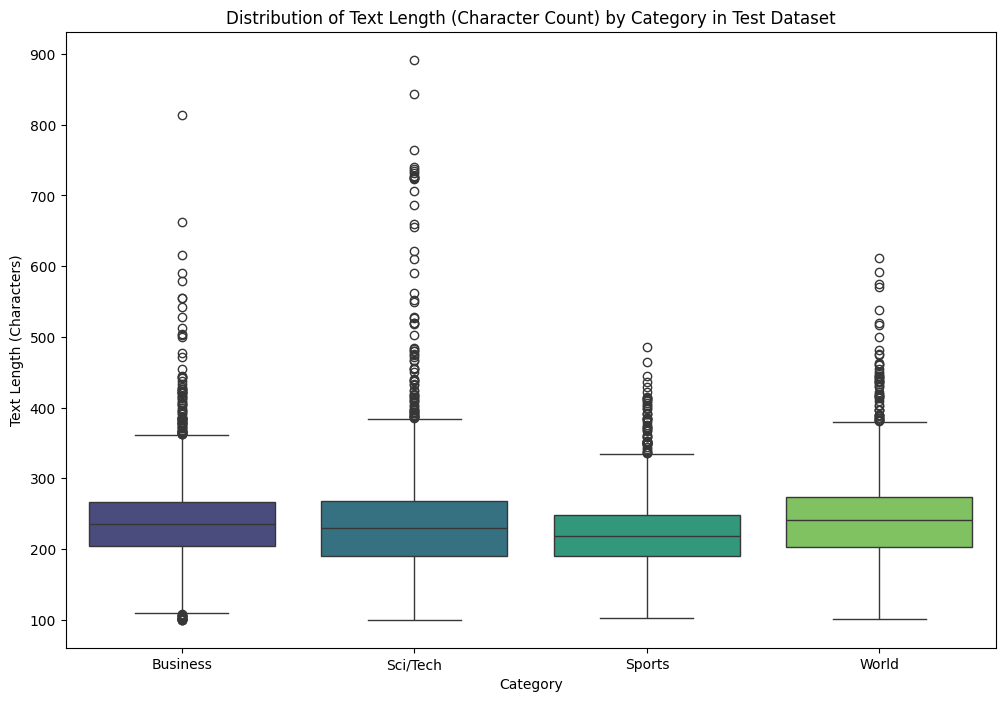

In [68]:
# Plot character count distribution by category for the test dataset
plot_char_count_distribution_by_category(test_df, "Test")

In [69]:
from wordcloud import WordCloud
def generate_word_clouds(df, category_column, text_column, label="Training"):

    # Ensure the 'Category' column exists
    if 'Category' not in df.columns:
        # Map numerical labels to category names
        category_mapping = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
        df['Category'] = df['label'].map(category_mapping)

    categories = df[category_column].unique()

    for category in categories:
        # Concatenate all text entries for the current category
        text = " ".join(df[df[category_column] == category][text_column].tolist())
        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        # Display the word cloud
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f"Word Cloud for {category} in {label} DataSet")
        plt.axis("off")
        plt.show()

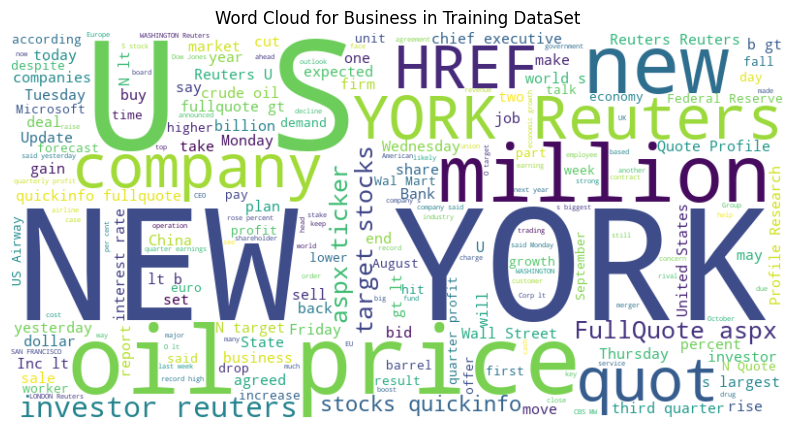

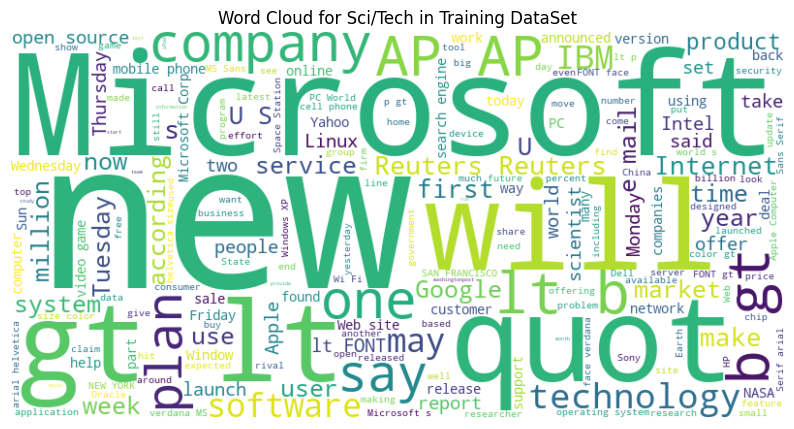

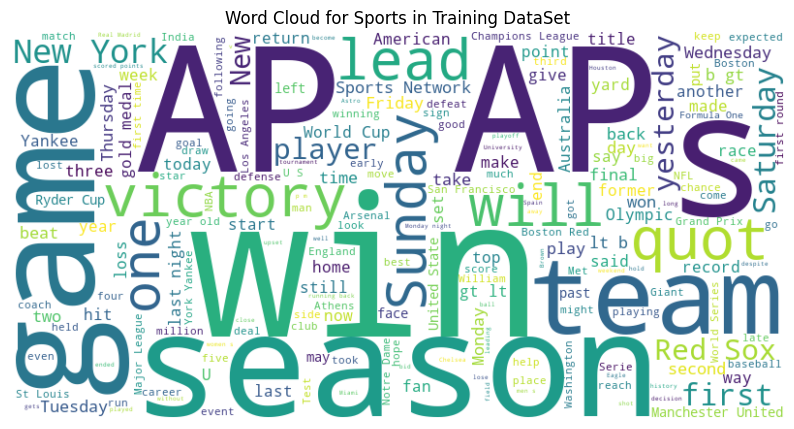

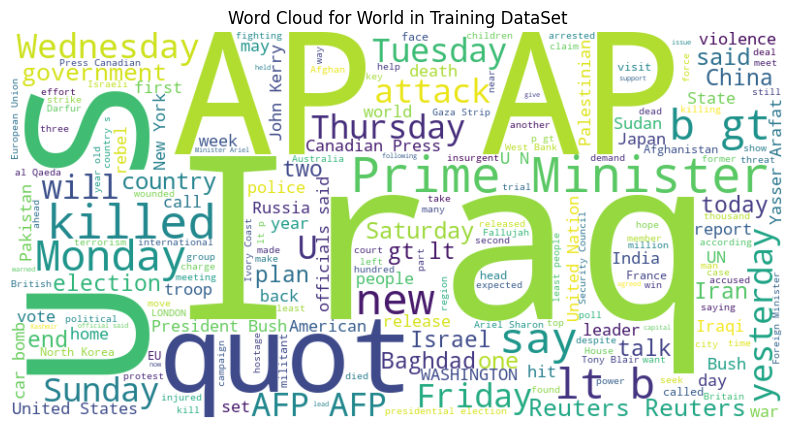

In [70]:
# Generate word clouds for each category in the training dataset
generate_word_clouds(train_df, 'Category', 'text')

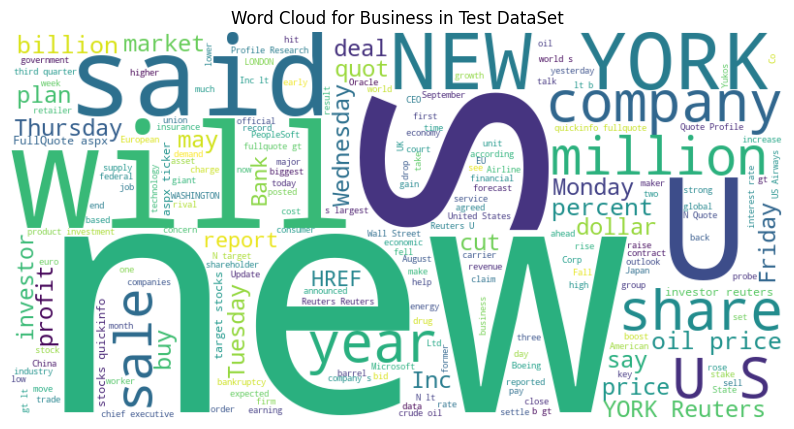

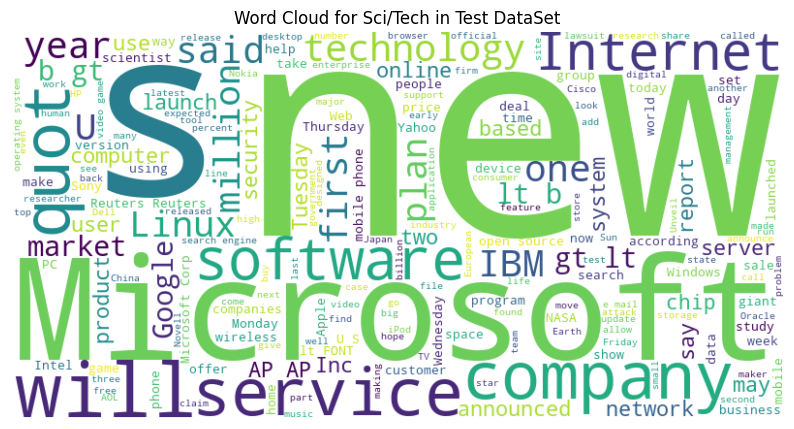

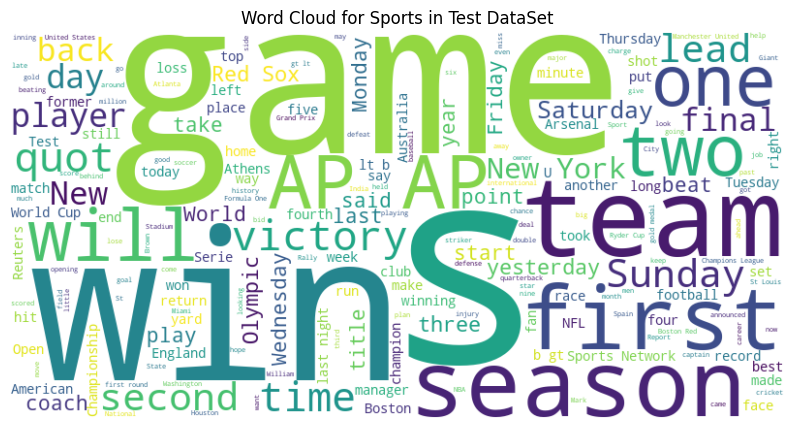

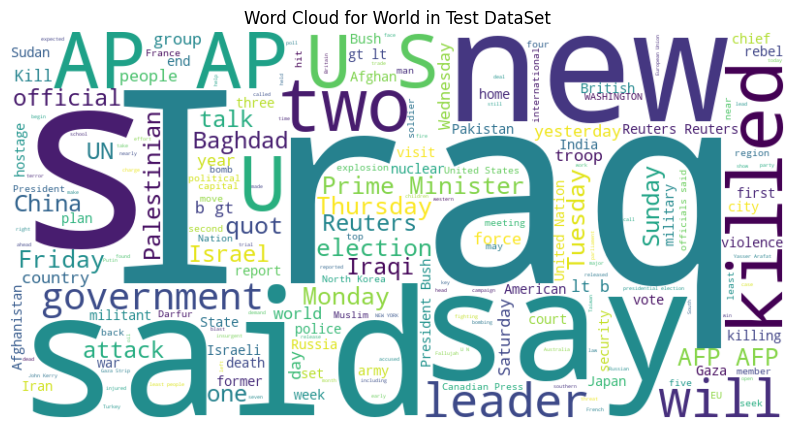

In [71]:
# Generate word clouds for each category in the test dataset
generate_word_clouds(test_df, 'Category', 'text', "Test")

In [72]:
from collections import Counter
import string

def plot_most_common_words(df, category_column, text_column, label="Training", top_n=20):
    categories = df[category_column].unique()

    for category in categories:
        # Filter rows for the current category
        category_texts = df[df[category_column] == category][text_column]

        # Combine all text data into a single string
        combined_text = ' '.join(category_texts)

        # Remove punctuation
        translator = str.maketrans('', '', string.punctuation)
        combined_text = combined_text.translate(translator)

        # Split text into words and convert to lowercase
        words = combined_text.lower().split()

        # Count word frequencies
        word_counts = Counter(words)

        # Get the most common words
        common_words = word_counts.most_common(top_n)

        # Create a DataFrame for plotting
        common_words_df = pd.DataFrame(common_words, columns=['word', 'count'])

        # Plot the data
        plt.figure(figsize=(10, 6))
        sns.barplot(x='count', y='word', data=common_words_df, hue='count', palette='viridis')
        plt.title(f'Most Common Words in {category} in {label} DataSet')
        plt.xlabel('Count')
        plt.ylabel('Word')
        plt.show()

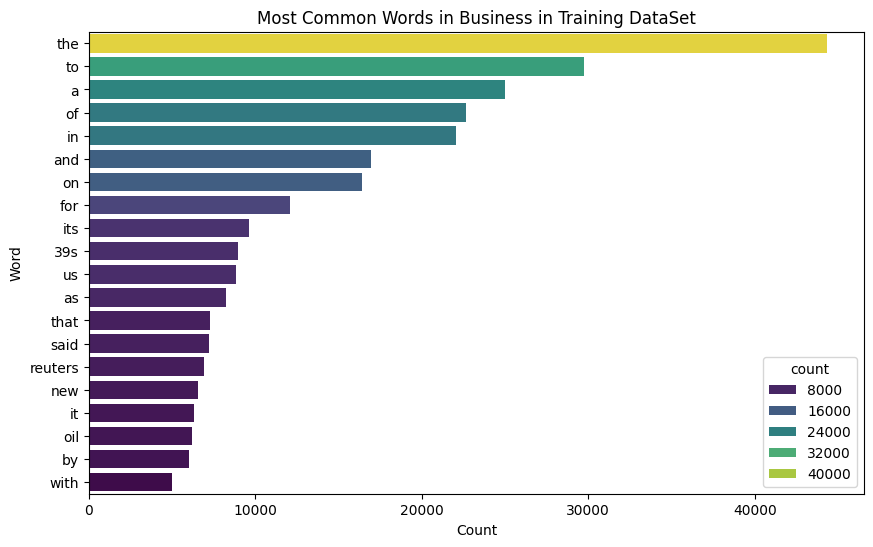

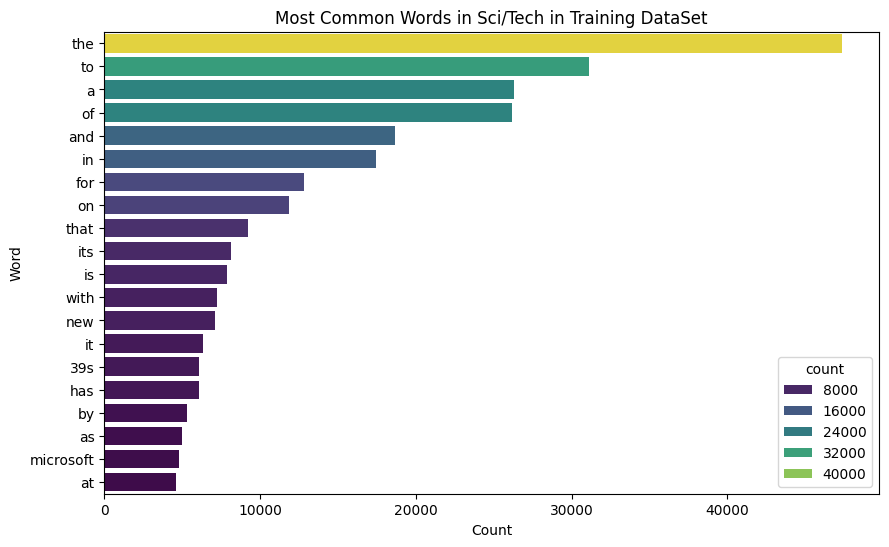

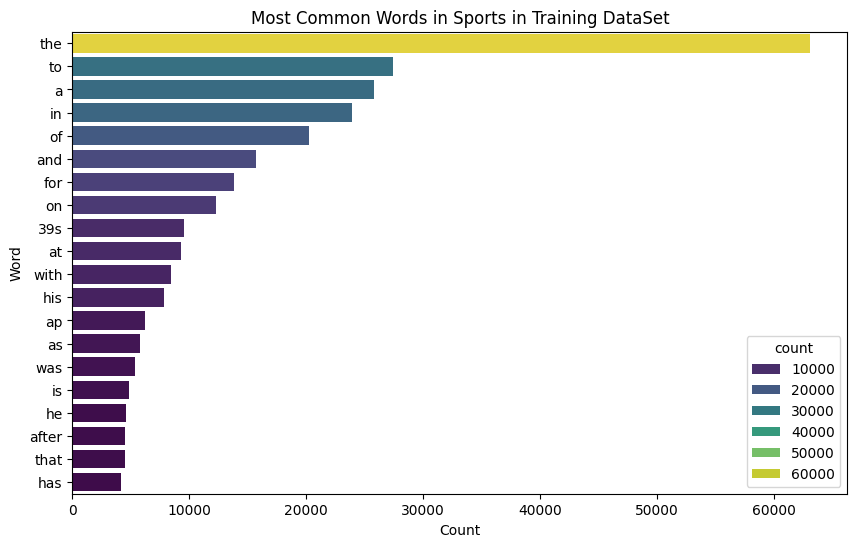

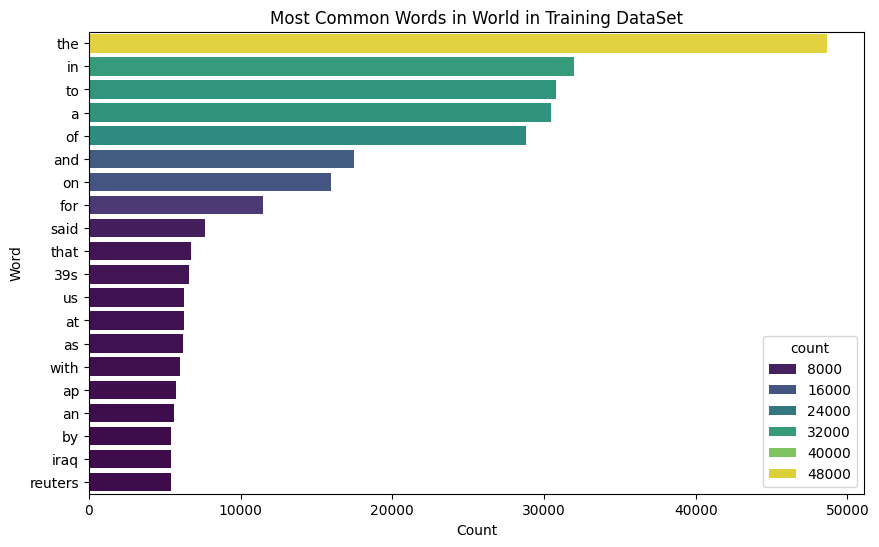

In [73]:
plot_most_common_words(train_df, 'Category', 'text')

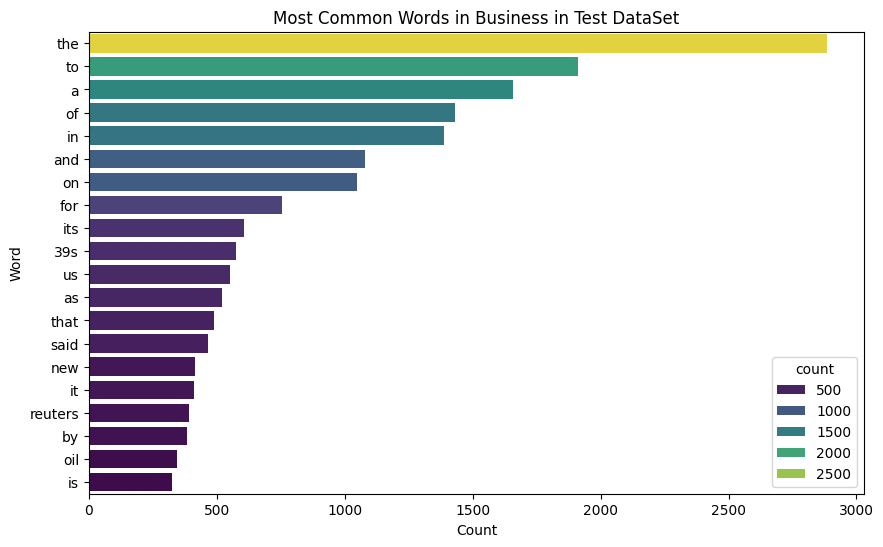

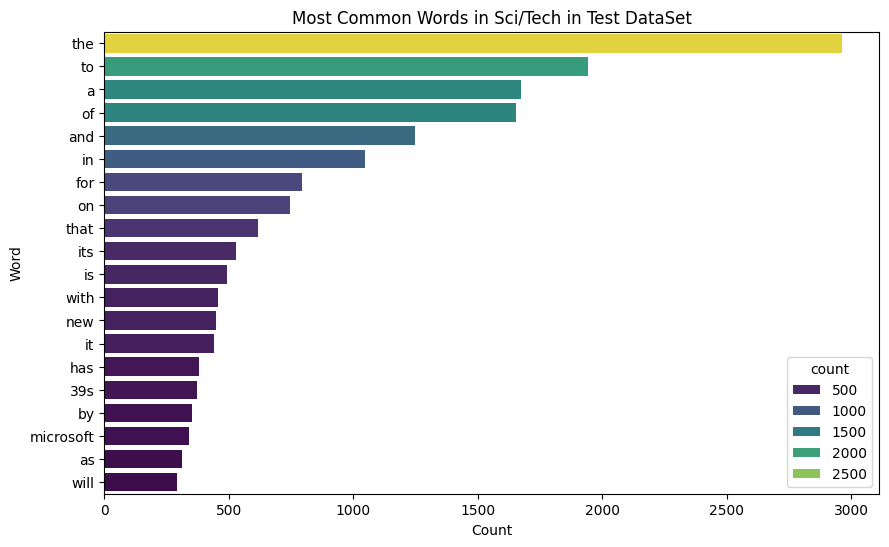

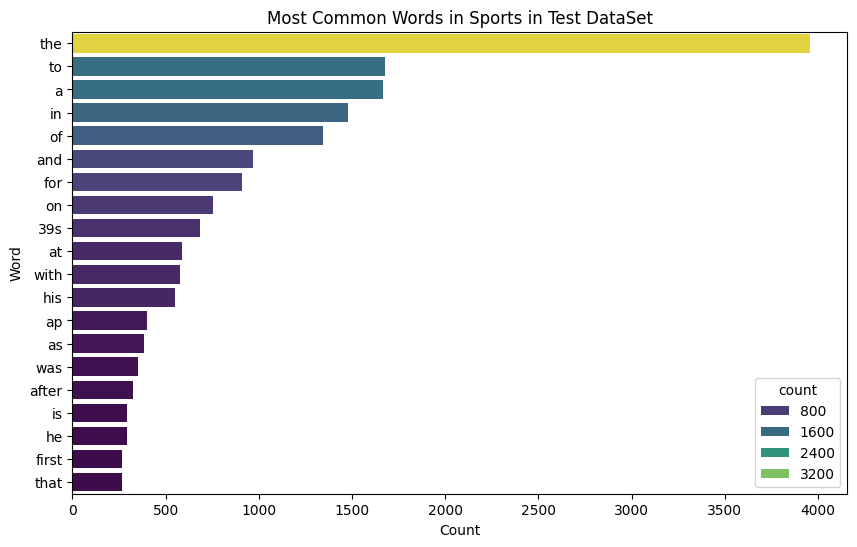

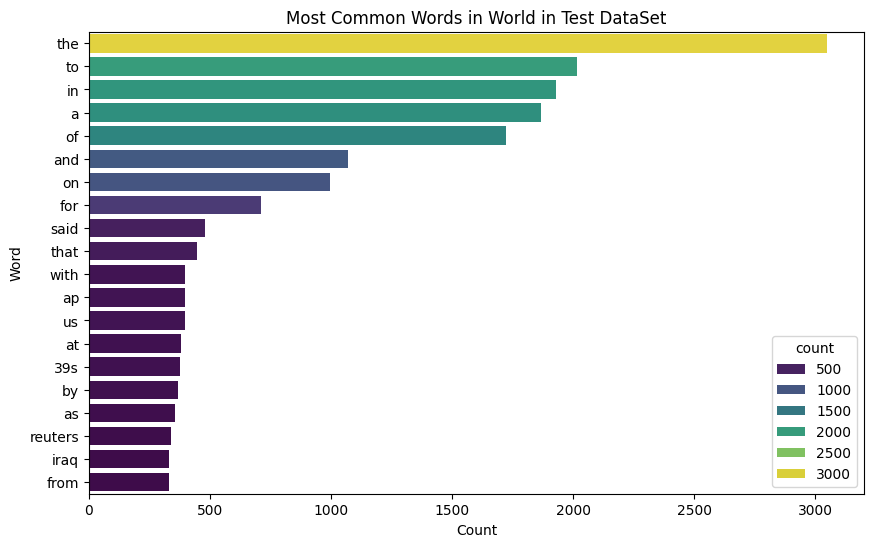

In [74]:
plot_most_common_words(test_df, 'Category', 'text', "Test")

## Data Preprocessing

In [75]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

### Data Cleaning

In [76]:
# Preprocess text data
def cleaning_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)  # Remove hashtags
    text = re.sub(r'RT[\s]+', '', text)  # Remove retweets
    text = re.sub(r'https?://\S+', '', text)  # Remove URLs
    text = re.sub(r'\n', '', text)  # Remove newlines
    return text

In [77]:
train_df['text'] = train_df['text'].apply(cleaning_text)
test_df['text'] = test_df['text'].apply(cleaning_text)
display(train_df.head())
test_df.head()

text  label  Category  \
0  wall st. bears claw back into the black (reute...      2  Business   
1  carlyle looks toward commercial aerospace (reu...      2  Business   
2  oil and economy cloud stocks' outlook (reuters...      2  Business   
3  iraq halts oil exports from main southern pipe...      2  Business   
4  oil prices soar to all-time record, posing new...      2  Business   

   text_length_char  
0               144  
1               266  
2               232  
3               256  
4               234

text  label  Category  \
0  fears for t n pension after talks unions repre...      2  Business   
1  the race is on: second private team sets launc...      3  Sci/Tech   
2  ky. company wins grant to study peptides (ap) ...      3  Sci/Tech   
3  prediction unit helps forecast wildfires (ap) ...      3  Sci/Tech   
4  calif. aims to limit farm-related smog (ap) ap...      3  Sci/Tech   

   text_length_char  
0               161  
1               321  
2               260  
3               318  
4               223

In [78]:
# Prepare Data for the MLP
# Apply cleaning to text data
train_texts = [cleaning_text(text) for text in dataset['train']['text']]
train_labels = dataset['train']['label']
test_texts = [cleaning_text(text) for text in dataset['test']['text']]
test_labels = dataset['test']['label']

### Sample from training set

In [79]:
def sample_train_dataset(train_df, sample_size=25000):
    # Shuffle the dataset to ensure randomness before sampling
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Initialize an empty DataFrame to store the reduced dataset
    reduced_train_df = pd.DataFrame()

    # Remove `sample_size` entries from each category
    categories = train_df['Category'].unique()
    for category in categories:
        category_data = train_df[train_df['Category'] == category]
        reduced_category_data = category_data.iloc[sample_size:]  # Keep all except the first `sample_size` entries
        reduced_train_df = pd.concat([reduced_train_df, reduced_category_data])

    # Shuffle the final reduced dataset
    reduced_train_df = reduced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Display the size of each category in the reduced dataset
    print(reduced_train_df['Category'].value_counts())

    return reduced_train_df

sampled_train_df = sample_train_dataset(train_df)

Category
Sci/Tech    5000
Business    5000
Sports      5000
World       5000
Name: count, dtype: int64


### Data Vectorization

In [80]:
vectorizer = TfidfVectorizer(max_features=4000, stop_words="english") # Default norm='l2'
# Each document vector is normalized so that its Euclidean norm equals 1

In [81]:
X_train = vectorizer.fit_transform(train_df['text']).toarray()
X_train_sampled = vectorizer.transform(sampled_train_df['text']).toarray()
X_train[0], X_train.shape

(array([0., 0., 0., ..., 0., 0., 0.], shape=(4000,)), (120000, 4000))

In [82]:
y_train_sampled = sampled_train_df['label']
y_train = train_df['label']
# Reshape y_train to a 2D array as required by OneHotEncoder
y_train_reshaped = np.array(y_train).reshape(-1, 1)

encoder = OneHotEncoder()
y_one_hot_train = encoder.fit_transform(y_train_reshaped)
y_one_hot_train = y_one_hot_train.toarray()

y_one_hot_train[0], y_one_hot_train.shape

(array([0., 0., 1., 0.]), (120000, 4))

In [83]:
X_test = vectorizer.transform(test_df['text']).toarray()
X_test[0], X_test.shape

(array([0., 0., 0., ..., 0., 0., 0.], shape=(4000,)), (7600, 4000))

In [84]:
y_test = test_df['label']

# Reshape y_train to a 2D array as required by OneHotEncoder
y_test_reshaped = np.array(y_test).reshape(-1, 1)

y_one_hot_test = encoder.transform(y_test_reshaped)
y_one_hot_test = y_one_hot_test.toarray()

y_one_hot_test[0], y_one_hot_test.shape

(array([0., 0., 1., 0.]), (7600, 4))

### Plotting Functions

In [85]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  # Define class names
  class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

  # Create a ConfusionMatrixDisplay instance
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

  # Plot the confusion matrix
  disp.plot(cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.show()

In [86]:
def plot_classification_report(y_true, y_pred):
  report = classification_report(y_true, y_pred)
  print(f'Classification Report:\n{report}')

## PCA (Principal Component Analysis)

> Due to time and space limitations we used the reduced data from our Custom PCA implementation to test the other algorithms, so you will need to run the cells of this section in order to run all the other algorithms. 

Key components include:

1. **Custom PCA Implementation**:
   - Implements PCA from scratch, including mean centering, covariance matrix computation, eigen decomposition, and projection onto the top principal components.
   - Calculates the explained variance ratio for each component to quantify the amount of variance captured.

2. **Explained Variance Analysis**:
   - The explained variance ratio is plotted to visualize the contribution of each principal component to the total variance.
   - A cumulative explained variance plot identifies the number of components required to achieve various variance thresholds (e.g., 40%, 50%, 90%).

3. **Dimensionality Reduction**:
   - PCA is applied to reduce the dimensionality of the training and test datasets while retaining the majority of the variance.
   - This step helps improve computational efficiency and mitigates issues related to high-dimensional data.

4. **Standardization**:
   - The PCA-transformed features are standardized to ensure compatibility with machine learning algorithms sensitive to feature scaling.

5. **Variance Thresholds**:
   - The number of principal components required to retain specific percentages of variance (e.g., 40%, 50%, 85%, 90%) is calculated and displayed.

6. **Key Insights**:
   - The reduced and standardized datasets are ready for subsequent classification tasks.
   - Metrics such as max, min, and mean values of TF-IDF features are reported before and after PCA to evaluate the impact of dimensionality reduction.


In [87]:
def plot_explained_variance_ratio(explained_variance_ratio):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
    plt.title('Explained Variance Ratio by Principal Component')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.grid()
    plt.show()

def plot_cumulative_explained_variance(pca):
    cumulative_variance = np.cumsum(pca.explained_variance_ratio)

    # Plot cumulative explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    plt.axhline(y=0.4, color='purple', linestyle='--', label='40% Variance')
    plt.axhline(y=0.5, color='brown', linestyle='--', label='50% Variance')
    plt.axhline(y=0.6, color='pink', linestyle='--', label='60% Variance')
    plt.axhline(y=0.7, color='orange', linestyle='--', label='70% Variance')
    plt.axhline(y=0.8, color='r', linestyle='--', label='80% Variance')
    plt.axhline(y=0.85, color='y', linestyle='--', label='85% Variance')
    plt.axhline(y=0.9, color='g', linestyle='--', label='90% Variance')
    plt.title("Cumulative Explained Variance by Principal Components")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.legend()
    plt.grid()
    plt.show()

def print_explained_variance_thresholds(pca):
    cumulative_variance = np.cumsum(pca.explained_variance_ratio)
    # Find the minimum number of components for different variance thresholds
    n_components_40 = np.argmax(cumulative_variance >= 0.4) + 1
    n_components_50 = np.argmax(cumulative_variance >= 0.5) + 1
    n_components_60 = np.argmax(cumulative_variance >= 0.6) + 1
    n_components_70 = np.argmax(cumulative_variance >= 0.7) + 1
    n_components_80 = np.argmax(cumulative_variance >= 0.8) + 1
    n_components_85 = np.argmax(cumulative_variance >= 0.85) + 1
    n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1
    if n_components_40 == 1: n_components_40 = str(pca.n_components) + "+"
    if n_components_50 == 1: n_components_50 = str(pca.n_components) + "+"
    if n_components_60 == 1: n_components_60 = str(pca.n_components) + "+"
    if n_components_70 == 1: n_components_70 = str(pca.n_components) + "+"
    if n_components_80 == 1: n_components_80 = str(pca.n_components) + "+"
    if n_components_85 == 1: n_components_85 = str(pca.n_components) + "+"
    if n_components_90 == 1: n_components_90 = str(pca.n_components) + "+"

    print(f"Number of principal components for 40% variance: {n_components_40}")
    print(f"Number of principal components for 50% variance: {n_components_50}")
    print(f"Number of principal components for 60% variance: {n_components_60}")
    print(f"Number of principal components for 70% variance: {n_components_70}")
    print(f"Number of principal components for 80% variance: {n_components_80}")
    print(f"Number of principal components for 85% variance: {n_components_85}")
    print(f"Number of principal components for 90% variance: {n_components_90}")

In [88]:
class CustomPCA:
    def __init__(self, n_components):
        """
        Principal Component Analysis (PCA) implementation.

        Parameters:
        - n_components: int, the number of principal components to retain.
        """
        self.n_components = n_components
        self.mean = None
        self.components = None
        self.explained_variance_ratio = None

    def fit_transform(self, X):
        """
        Fits the PCA model on the input data and transforms it to the reduced dimensionality.

        Parameters:
        - X: numpy.ndarray, shape (n_samples, n_features). The input data.

        Returns:
        - X_reduced: numpy.ndarray, shape (n_samples, n_components). The reduced data.
        """
        # Step 1: Standardize the data (mean-centered)
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # Step 2: Compute the covariance matrix
        covariance_matrix = np.dot(X_centered.T, X_centered) / (X_centered.shape[0] - 1)

        # Step 3: Perform eigen decomposition using SVD
        U, S, Vt = np.linalg.svd(covariance_matrix)
        eigenvalues = S
        eigenvectors = U

        # Step 4: Sort eigenvalues and eigenvectors in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]

        # Step 5: Select the top n_components eigenvectors
        self.components = eigenvectors[:, :self.n_components]

        # Step 6: Project the data onto the Principal Components (top eigenvectors)
        X_reduced = np.dot(X_centered, self.components)

        # Step 7: Calculate explained variance ratio
        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio = eigenvalues[:self.n_components] / total_variance

        return X_reduced

    def transform(self, X):
        """
        Transforms new data using the PCA model fitted on the training data.

        Parameters:
        - X: numpy.ndarray, shape (n_samples, n_features). The input data.

        Returns:
        - X_reduced: numpy.ndarray, shape (n_samples, n_components). The reduced data.
        """
        if self.mean is None or self.components is None:
            raise ValueError("PCA has not been fitted yet. Call 'fit_transform' first.")

        # Center the data using the mean from the training set
        X_centered = X - self.mean

        # Project the data onto the top eigenvectors
        X_reduced = np.dot(X_centered, self.components)
        return X_reduced

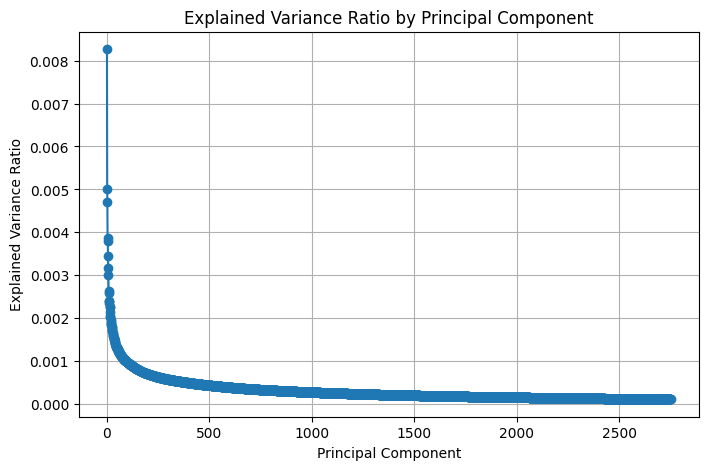

In [89]:
# Perform PCA
pca = CustomPCA(n_components=2750)

# Fit PCA on training data
pca.fit_transform(X_train)

# Plot explained variance ratio
plot_explained_variance_ratio(pca.explained_variance_ratio)

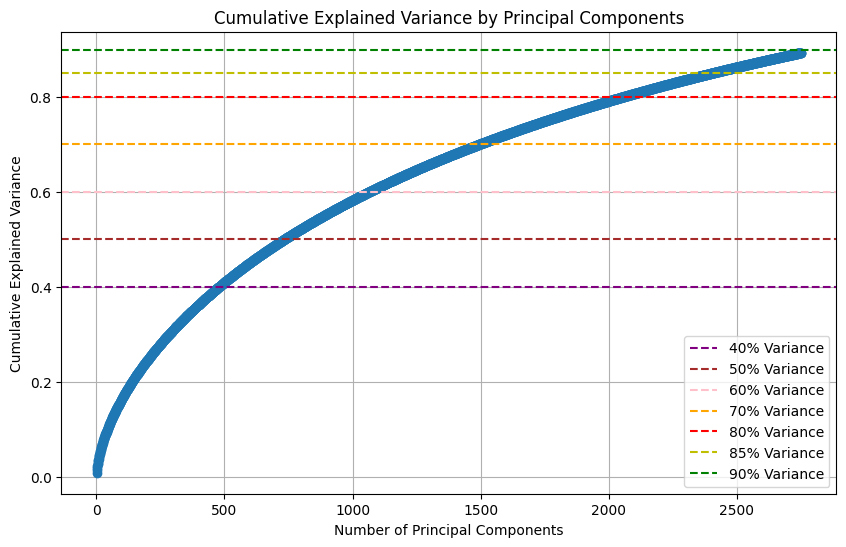

In [90]:
plot_cumulative_explained_variance(pca)

In [91]:
print_explained_variance_thresholds(pca)

Number of principal components for 40% variance: 479
Number of principal components for 50% variance: 734
Number of principal components for 60% variance: 1065
Number of principal components for 70% variance: 1493
Number of principal components for 80% variance: 2053
Number of principal components for 85% variance: 2400
Number of principal components for 90% variance: 2750+


#### Sci-kit Learn Implementation

In [92]:
# from sklearn.decomposition import PCA
# sklearn_pca = PCA(n_components=500)
# # Fit PCA on training data
# sklearn_pca.fit(X_train)

# # Plot explained variance ratio
# plot_explained_variance_ratio(sklearn_pca.explained_variance_ratio)
# # Plot number of PCs vs the % of the variance they explain
# plot_cumulative_explained_variance(sklearn_pca)
# # Print number of PCs needed to explain various % of the variance
# print_explained_variance_thresholds(sklearn_pca)

#### Project the data to a low-dimensional space

In [93]:
# Perform PCA
from sklearn.discriminant_analysis import StandardScaler
pca = CustomPCA(n_components=500)

# Fit PCA on training data and reduce its dimensionality
X_train_reduced = pca.fit_transform(X_train_sampled)
# Reduce the dimensionality of the test data as well
X_test_reduced = pca.transform(X_test)
X_train_reduced.shape, X_test_reduced.shape

# Standardize the PCA output
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled = scaler.transform(X_test_reduced)

In [94]:
print(f"Max TF-IDF value: {X_train.max()} | Min TF-IDF value: {X_train.min()} | Mean TF-IDF value: {X_train.mean()}")
print(f"Max TF-IDF value (sampled): {X_train_sampled.max()} | Min TF-IDF value (sampled): {X_train_sampled.min()} | Mean TF-IDF value (sampled): {X_train_sampled.mean()}")
print(f"Max TF-IDF value (sampled and reduced): {X_train_reduced.max()} | Min TF-IDF value (sampled and reduced): {X_train_reduced.min()} | Mean TF-IDF value (sampled and reduced): {X_train_reduced.mean()}")
print(f"Max TF-IDF value (sampled and reduced and scaled): {X_train_scaled.max()} | Min TF-IDF value (sampled and reduced and scaled): {X_train_scaled.min()} | Mean TF-IDF value (sampled and reduced and scaled): {X_train_scaled.mean()}")

Max TF-IDF value: 1.0 | Min TF-IDF value: 0.0 | Mean TF-IDF value: 0.0009391176359714228
Max TF-IDF value (sampled): 0.9435260475631166 | Min TF-IDF value (sampled): 0.0 | Mean TF-IDF value (sampled): 0.0009383540864651582
Max TF-IDF value (sampled and reduced): 0.7634747964283098 | Min TF-IDF value (sampled and reduced): -0.5804953566390039 | Mean TF-IDF value (sampled and reduced): 1.7601475832407232e-19
Max TF-IDF value (sampled and reduced and scaled): 11.452022532949107 | Min TF-IDF value (sampled and reduced and scaled): -11.210368008652033 | Mean TF-IDF value (sampled and reduced and scaled): -1.1723955140041653e-18


## Least Squares

This implementation leverages the Least Squares method to minimize the cost function in a multi-class setting.

Key components include:

1. **Cost Computation**:
   - The cost function computes the mean squared error (MSE) between predicted and true labels, with support for one-hot encoded multi-class labels.
   - Incorporates L2 regularization to prevent overfitting.

2. **Stochastic Gradient Descent (SGD)**:
   - Optimizes the parameters iteratively by updating them based on a randomly chosen data sample.
   - Includes L2 regularization in gradient computation for robust parameter optimization.
   - Tracks cost reduction over iterations to visualize convergence.

3. **Visualization**:
   - The cost function value is plotted against the number of iterations to illustrate the model's optimization progress.

In [41]:
def computeCost( X, Y, Theta ):
    """
    Compute the cost J for our linear model in a multiclass setting.
    X: (N, D) data/feature matrix
    Y: (N, C) ground truth one-hot label matrix
    Theta: (D, C) parameter matrix
    """

    N = X.shape[0] #number of training examples

    # Predictions: (N, C)
    Y_pred = X.dot(Theta)

    # Calculate squared errors: (N, C)
    error = Y_pred - Y
    cost = (1.0 / (2 * N)) * np.sum(error**2)

    return cost

In [42]:
def stochasticGradientDescent(X, Y, Theta=None, alpha=0.01, num_iters=1000, lambda_reg=0.01):
    """
    Performs stochastic gradient descent to optimize the parameters Theta with L2 regularization.

    Parameters:
    -----------
    X : numpy.ndarray
        Input features matrix of shape (N, D), where N is the number of samples
        and D is the number of features.
    Y : numpy.ndarray
        Target values matrix of shape (N, C), where N is the number of samples
        and C is the number of classes.
    Theta : numpy.ndarray, optional
        Initial parameters matrix of shape (D, C). If None, initialized to zeros.
    alpha : float, optional (default=0.01)
        Learning rate that determines the step size of parameter updates.
    num_iters : int, optional (default=1000)
        Number of iterations to run the optimization algorithm.
    lambda_reg : float, optional (default=0.01)
        Regularization parameter that controls the strength of L2 regularization.

    Returns:
    --------
    Theta : numpy.ndarray
        Optimized parameters matrix of shape (D, C).
    J_history : numpy.ndarray
        Array of cost values at each iteration, shape (num_iters,).
    """
    N, D = X.shape
    C = Y.shape[1]

    if Theta is None:
        Theta = np.zeros((D, C))

    J_history = np.zeros(num_iters)

    for i in range(num_iters):
        # Pick a random index
        idx = np.random.randint(N)
        X_i = X[idx:idx+1, :]  # (1, D)
        Y_i = Y[idx:idx+1, :]  # (1, C)

        # Compute prediction
        Y_pred_i = X_i.dot(Theta)  # (1, C)

        # Compute error for this one sample
        error_i = Y_pred_i - Y_i  # (1, C)

        # Compute gradient w.r.t this sample with L2 regularization
        grad_i = X_i.T.dot(error_i) + lambda_reg * Theta  # (D, C)

        # Update Theta
        Theta = Theta - alpha * grad_i

        # Compute cost with regularization
        cost = (1.0 / (2 * N)) * np.sum((X.dot(Theta) - Y) ** 2) + (lambda_reg / 2) * np.sum(Theta ** 2)
        J_history[i] = cost

    return Theta, J_history

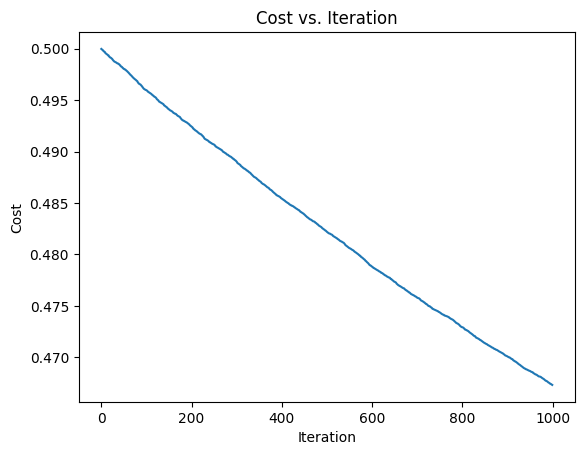

In [43]:
Theta_optimized, cost_history = stochasticGradientDescent(
    X=X_train,
    Y=y_one_hot_train
)

plt.plot(cost_history)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost vs. Iteration')
plt.show()

In [44]:
Y_train_pred = np.argmax(X_train.dot(Theta_optimized), axis=1)

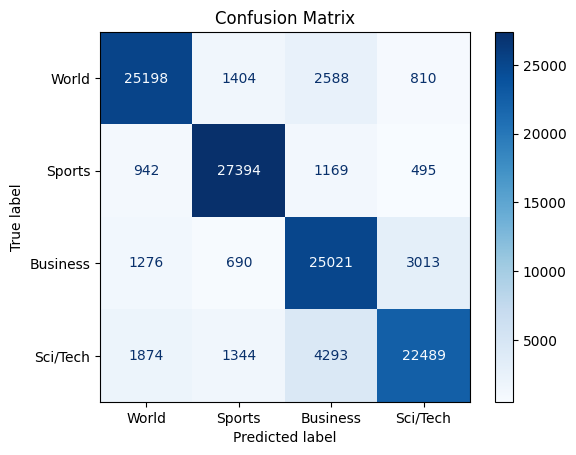

In [45]:
plot_confusion_matrix(y_train, Y_train_pred)

In [46]:
plot_classification_report(y_train, Y_train_pred)

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     30000
           1       0.89      0.91      0.90     30000
           2       0.76      0.83      0.79     30000
           3       0.84      0.75      0.79     30000

    accuracy                           0.83    120000
   macro avg       0.84      0.83      0.83    120000
weighted avg       0.84      0.83      0.83    120000



In [47]:
Y_test_pred = np.argmax(X_test.dot(Theta_optimized), axis=1)

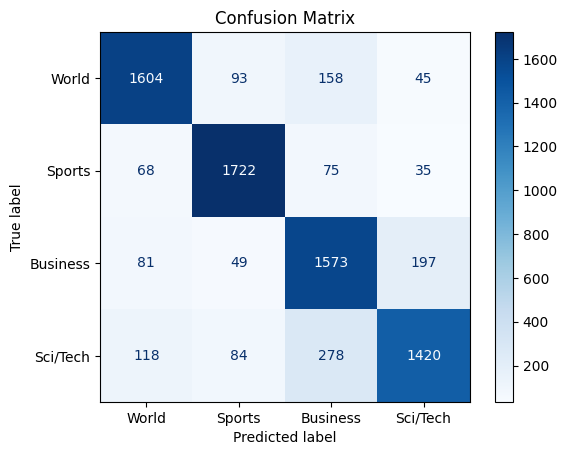

In [48]:
plot_confusion_matrix(y_test, Y_test_pred)

In [49]:
plot_classification_report(y_test, Y_test_pred)

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1900
           1       0.88      0.91      0.90      1900
           2       0.75      0.83      0.79      1900
           3       0.84      0.75      0.79      1900

    accuracy                           0.83      7600
   macro avg       0.83      0.83      0.83      7600
weighted avg       0.83      0.83      0.83      7600



#### Sci-kit Learn Implementation

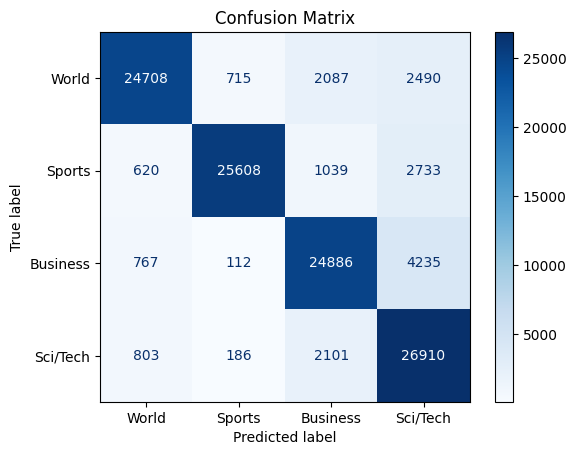

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.82      0.87     30000
           1       0.96      0.85      0.90     30000
           2       0.83      0.83      0.83     30000
           3       0.74      0.90      0.81     30000

    accuracy                           0.85    120000
   macro avg       0.86      0.85      0.85    120000
weighted avg       0.86      0.85      0.85    120000



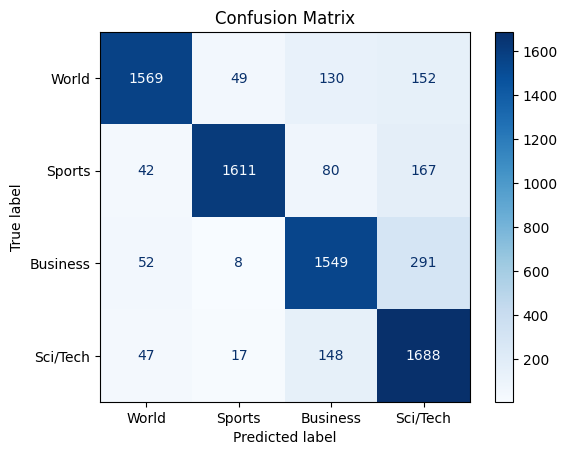

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1900
           1       0.96      0.85      0.90      1900
           2       0.81      0.82      0.81      1900
           3       0.73      0.89      0.80      1900

    accuracy                           0.84      7600
   macro avg       0.86      0.84      0.85      7600
weighted avg       0.86      0.84      0.85      7600



In [50]:
from sklearn.linear_model import SGDClassifier
# Initialize the SGDClassifier with squared loss
sgd_classifier = SGDClassifier(
    loss='squared_error',     # Least squares loss
    max_iter=1000,            # Maximum number of iterations
    eta0=0.01,                # Initial learning rate
    learning_rate='constant', # Constant learning rate
    alpha=0.01,             # L2 regularization strength
    penalty='l2',             # L2 regularization
    tol=None,
    random_state=42
)

# Fit the model to the training datap
sgd_classifier.fit(X_train, y_train)
# Predict on the training data
y_train_pred_skl = sgd_classifier.predict(X_train)
# Calculate eval metrics on training data
plot_confusion_matrix(y_train, y_train_pred_skl)
plot_classification_report(y_train, y_train_pred_skl)
# Predict on the test data
y_test_pred_skl = sgd_classifier.predict(X_test)
# Calculate eval metrics on test data
plot_confusion_matrix(y_test, y_test_pred_skl)
plot_classification_report(y_test, y_test_pred_skl)

## Logistic Regression

This implementation demonstrates logistic regression optimized using Stochastic Gradient Descent (SGD).


### Key Concepts

1. **Sigmoid and Softmax Functions**
   - These are activation functions used in logistic regression:
     - **Sigmoid Function**:
       - Primarily used for binary classification.
       - Maps any real number into a range between 0 and 1.
     - **Softmax Function**:
       - Converts raw model outputs (logits) into probabilities for multi-class classification.
       - Ensures the output probabilities for all classes sum to 1.

2. **Cross-Entropy Loss**
   - The cross-entropy loss function measures the difference between the predicted probabilities and the true labels.
   - It is commonly used for classification tasks and ensures that the model improves its prediction probabilities for the correct classes.

3. **Stochastic Gradient Descent (SGD)**
   - **Mini-Batch Processing**:
     - Data is divided into smaller subsets (mini-batches).
     - Each mini-batch is used to compute gradients and update the model parameters, which improves computational efficiency and reduces memory usage.
   - **Weight Updates**:
     - Gradients of the loss with respect to the weights are computed using the chain rule.
     - Weights and biases are then updated iteratively to minimize the loss.

4. **Visualization**
   - The loss function value is plotted against the number of epochs.
   - This visual representation helps track the optimization progress of the model and indicates whether the training is converging properly.

In [51]:
# Logistic Regression using Stochastic Gradient Descent
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    n_samples = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-15)) / n_samples

def logistic_regression_sgd(X, Y, alpha=0.01, num_epochs=1000, batch_size=32):
    """
    Logistic Regression with SGD optimization
    Parameters:
        X : numpy.ndarray
            Input features of shape (N, D)
        Y : numpy.ndarray
            One-hot encoded target labels of shape (N, C)
        alpha : float
            Learning rate
        num_epochs : int
            Number of epochs for training
        batch_size : int
            Size of mini-batches
    Returns:
        weights : numpy.ndarray
            Optimized weight matrix
        biases : numpy.ndarray
            Optimized bias vector
        loss_history : list
            History of loss values
    """
    N, D = X.shape
    C = Y.shape[1]

    # Initialize weights and biases
    weights = np.random.randn(D, C) * 0.01
    biases = np.zeros((1, C))
    loss_history = []

    for epoch in range(num_epochs):
        indices = np.arange(N)
        np.random.shuffle(indices)
        X = X[indices]
        Y = Y[indices]

        for i in range(0, N, batch_size):
            X_batch = X[i:i + batch_size]
            Y_batch = Y[i:i + batch_size]

            # Forward pass
            logits = np.dot(X_batch, weights) + biases
            predictions = softmax(logits)

            # Compute gradients
            errors = predictions - Y_batch
            dW = np.dot(X_batch.T, errors) / batch_size
            dB = np.sum(errors, axis=0, keepdims=True) / batch_size

            # Update weights and biases
            weights -= alpha * dW
            biases -= alpha * dB

        # Compute loss for the epoch
        logits_train = np.dot(X, weights) + biases
        predictions_train = softmax(logits_train)
        loss = cross_entropy_loss(predictions_train, Y)
        loss_history.append(loss)

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}")

    return weights, biases, loss_history

In [52]:
# Training logistic regression
weights, biases, loss_history = logistic_regression_sgd(
    X=X_train,
    Y=y_one_hot_train,
    alpha=0.01,
    num_epochs=3,
    batch_size=16
)

# Evaluation on test set
logits_train = np.dot(X_train, weights) + biases
predictions_train= softmax(logits_train)
predicted_classes_train = np.argmax(predictions_train, axis=1)

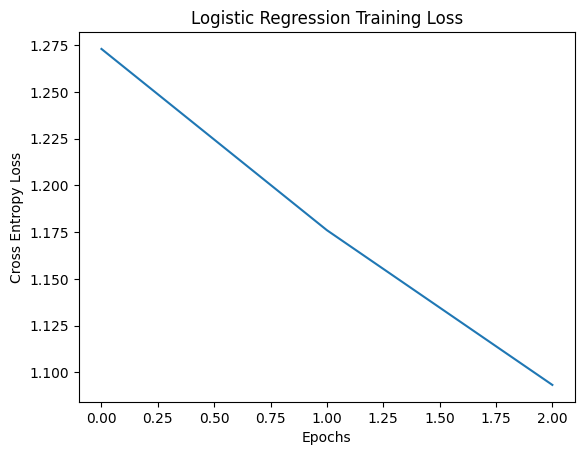

In [53]:
# Plot training loss
plt.plot(range(len(loss_history)), loss_history)
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.title("Logistic Regression Training Loss")
plt.show()

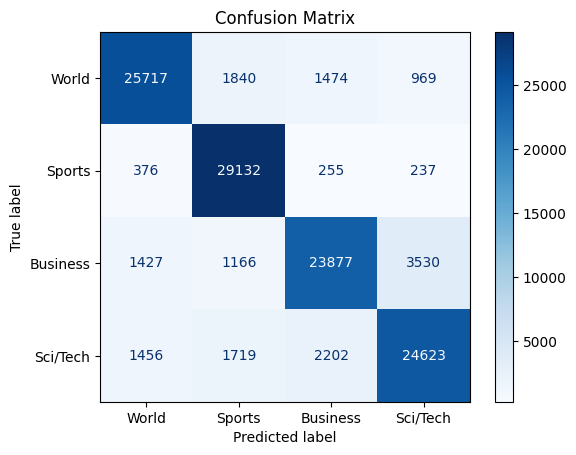

In [54]:
plot_confusion_matrix(y_train, predicted_classes_train)

In [55]:
plot_classification_report(y_train, predicted_classes_train)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87     30000
           1       0.86      0.97      0.91     30000
           2       0.86      0.80      0.83     30000
           3       0.84      0.82      0.83     30000

    accuracy                           0.86    120000
   macro avg       0.86      0.86      0.86    120000
weighted avg       0.86      0.86      0.86    120000



In [56]:
# Evaluation on test set
logits_test = np.dot(X_test, weights) + biases
predictions_test = softmax(logits_test)
predicted_classes_test = np.argmax(predictions_test, axis=1)

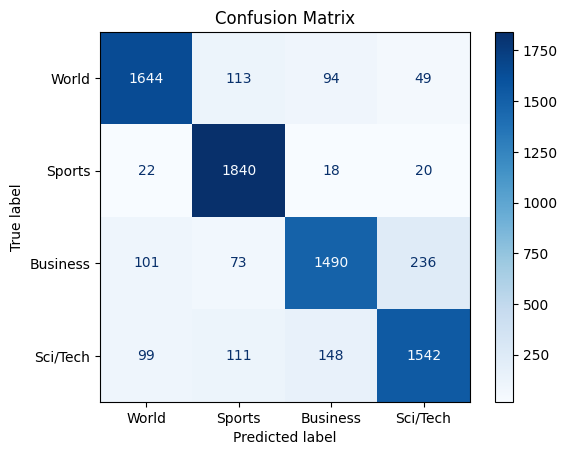

In [57]:
plot_confusion_matrix(y_test, predicted_classes_test)

In [58]:
plot_classification_report(y_test, predicted_classes_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1900
           1       0.86      0.97      0.91      1900
           2       0.85      0.78      0.82      1900
           3       0.83      0.81      0.82      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600



#### Sci-kit Learn Implementation

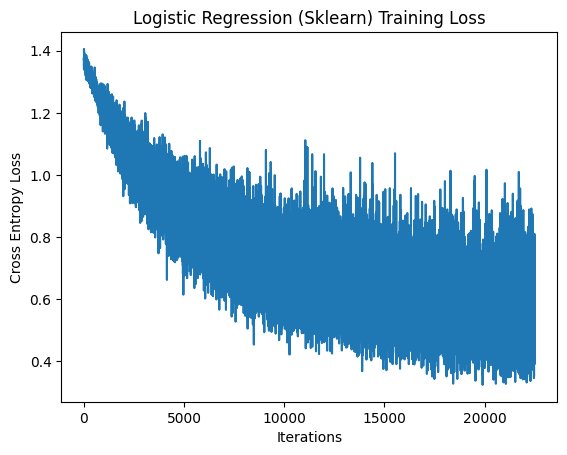

In [59]:
from sklearn.linear_model import SGDClassifier
# Initialize the SGDClassifier with log_loss
log_reg_classifier = SGDClassifier(
    loss='log_loss',          # Logistic regression with cross-entropy loss
    max_iter=1,               # Perform a single iteration at a time
    learning_rate="constant", # Constant learning rate
    eta0=0.01,                # Initial learning rate
    penalty='l2',             # L2 Regularization
    tol=None,                 # Disable early stopping
    random_state=42
)

# Track the loss history
skl_loss_history = []
n_epochs = 3
batch_size = 16

for epoch in range(n_epochs):
    # Shuffle data at the beginning of each epoch
    permutation = np.random.permutation(len(X_train))
    X_train_shuffled = X_train[permutation]
    y_train_shuffled = y_train[permutation]

    for i in range(0, len(X_train), batch_size):
        # Create a mini-batch
        X_batch = X_train_shuffled[i:i + batch_size]
        y_batch = y_train_shuffled[i:i + batch_size]

        # Perform a partial fit on the mini-batch
        if epoch == 0 and i == 0:
            # Initialize the classifier
            log_reg_classifier.partial_fit(X_batch, y_batch, classes=np.unique(y_train))
        else:
            log_reg_classifier.partial_fit(X_batch, y_batch)

        # Compute and store the loss for the current batch
        y_pred_proba = log_reg_classifier._predict_proba_lr(X_batch)
        loss = -np.mean(np.log(y_pred_proba[np.arange(len(y_batch)), y_batch]))
        skl_loss_history.append(loss)

# Plot training loss
plt.plot(range(len(skl_loss_history)), skl_loss_history)
plt.xlabel("Iterations")
plt.ylabel("Cross Entropy Loss")
plt.title("Logistic Regression (Sklearn) Training Loss")
plt.show()

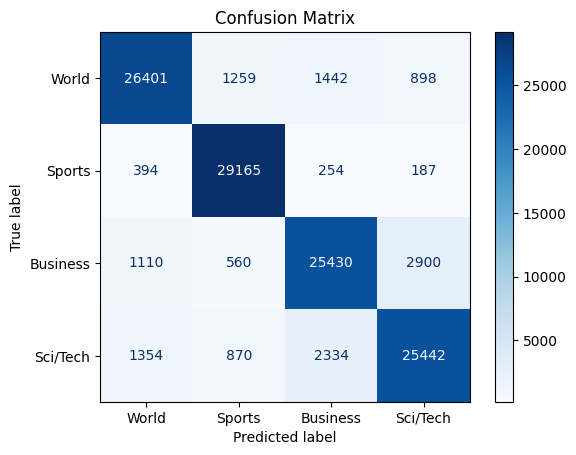

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     30000
           1       0.92      0.97      0.94     30000
           2       0.86      0.85      0.86     30000
           3       0.86      0.85      0.86     30000

    accuracy                           0.89    120000
   macro avg       0.89      0.89      0.89    120000
weighted avg       0.89      0.89      0.89    120000



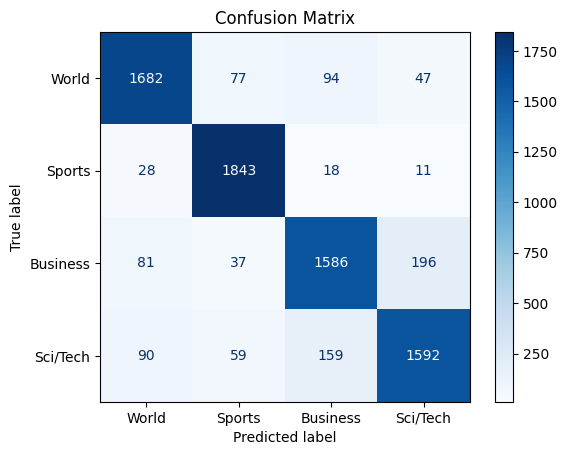

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1900
           1       0.91      0.97      0.94      1900
           2       0.85      0.83      0.84      1900
           3       0.86      0.84      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600



In [60]:
# Predict on the training data
y_train_pred_skl = log_reg_classifier.predict(X_train)
# Calculate eval metrics on training data
plot_confusion_matrix(y_train, y_train_pred_skl)
plot_classification_report(y_train, y_train_pred_skl)
# Predict on the test data
y_test_pred_skl = log_reg_classifier.predict(X_test)
# Calculate eval metrics on test data
plot_confusion_matrix(y_test, y_test_pred_skl)
plot_classification_report(y_test, y_test_pred_skl)

## K Nearest Neighbors

This implementation of the K-Nearest Neighbors (KNN) algorithm is designed for classification tasks.
Key features include:

1. **Initialization**:
   - Allows the user to specify the number of neighbors (`k`) to consider for classification.

2. **Training**:
   - The `fit()` method stores the training data (`X_train`) and corresponding labels (`y_train`) for use during prediction.

3. **Prediction**:
   - The `predict()` method determines the class labels for a set of test points by:
     - Calculating the Euclidean distance from the test point to all training points.
     - Selecting the `k` nearest neighbors based on the smallest distances.
     - Determining the majority class among the nearest neighbors.

4. **Single Prediction**:
   - The `_predict_single()` method performs the above steps for a single test point.

In [61]:
class KNNClassifier:
    def __init__(self, k=3):
        """
        Initialize the KNN classifier with the specified number of neighbors.
        """
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """
        Store the training data.
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X_test):
        """
        Predict the class labels for the given test data.
        """
        if self.X_train is None or self.y_train is None:
            raise ValueError("The classifier has not been trained yet. You need to call `fit()` before making any predictions.")
        predictions = [self._predict_single(x) for x in X_test]
        return np.array(predictions)

    def _predict_single(self, x):
        """
        Predict the class label for a single test point.
        """
        # Compute squared distances from the test point to all training points
        distances = np.sum((self.X_train - x) ** 2, axis=1)

        # Get the indices of the k nearest neighbors
        k_indices = np.argsort(distances)[:self.k]

        # Get the labels of the k nearest neighbors
        k_nearest_labels = self.y_train[k_indices]

        # Determine the majority class
        most_common = Counter(k_nearest_labels).most_common(1)[0][0]
        return most_common

(Sampled and Reduced) Data used:
- Train: (20000, 500)
- Test: (7600, 500)

Fitting KNN model with k = 1..
(Test) Accuracy: 0.724
Fitting KNN model with k = 2..
(Test) Accuracy: 0.724
Fitting KNN model with k = 3..
(Test) Accuracy: 0.734
Fitting KNN model with k = 4..
(Test) Accuracy: 0.738
Fitting KNN model with k = 5..
(Test) Accuracy: 0.734
Fitting KNN model with k = 6..
(Test) Accuracy: 0.733
Fitting KNN model with k = 7..
(Test) Accuracy: 0.729
Fitting KNN model with k = 8..
(Test) Accuracy: 0.734
Fitting KNN model with k = 9..
(Test) Accuracy: 0.732
Fitting KNN model with k = 10..
(Test) Accuracy: 0.731

Best k is 4 with accuracy: 0.738


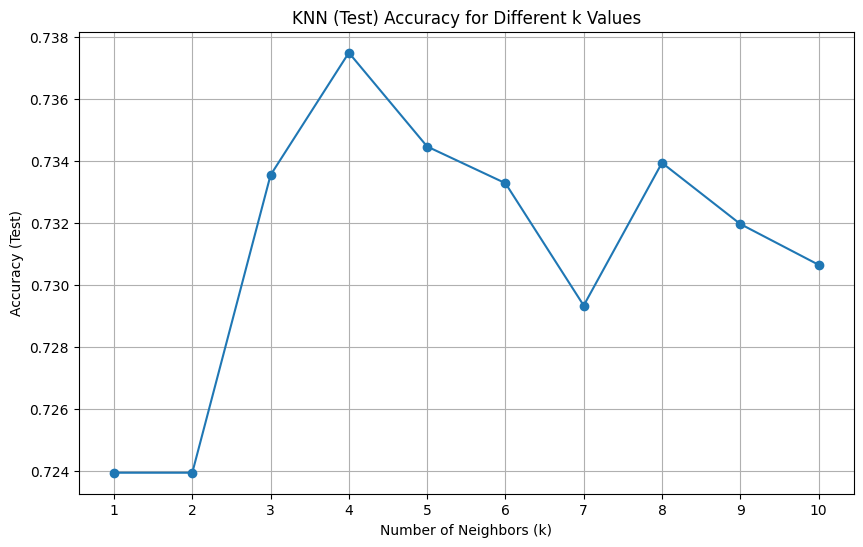

In [62]:
print(f"(Sampled and Reduced) Data used:\n- Train: {X_train_reduced.shape}\n- Test: {X_test_reduced.shape}\n")
# 0.70 with k=3

# Placeholder for accuracies
k_values = range(1, 11)
accuracies = []
models = []

# Iterate over values of k
for k in k_values:
    print(f"Fitting KNN model with k = {k}..")
    knn = KNNClassifier(k=k)
    knn.fit(X_train_reduced, y_train_sampled)
    y_pred = knn.predict(X_test_reduced)

    # Compute accuracy
    accuracy = np.mean(y_pred == y_test)
    accuracies.append(accuracy)
    print(f"(Test) Accuracy: {accuracy:.3f}")

# Find the best k
best = np.argmax(accuracies)
best_k = k_values[best]
print(f"\nBest k is {best_k} with accuracy: {max(accuracies):.3f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title("KNN (Test) Accuracy for Different k Values")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy (Test)")
plt.xticks(k_values)
plt.grid()
plt.show()

In [63]:
best_knn = KNNClassifier(k=best_k)
best_knn.fit(X_train_reduced, y_train_sampled)

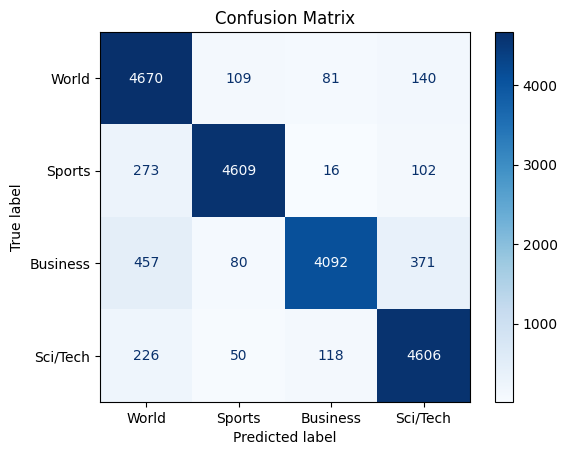

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      5000
           1       0.95      0.92      0.94      5000
           2       0.95      0.82      0.88      5000
           3       0.88      0.92      0.90      5000

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000



In [64]:
# Show best KNN Classifier's Results on the Training Set
y_train_pred = best_knn.predict(X_train_reduced)
plot_confusion_matrix(y_train_sampled, y_train_pred)
plot_classification_report(y_train_sampled, y_train_pred)

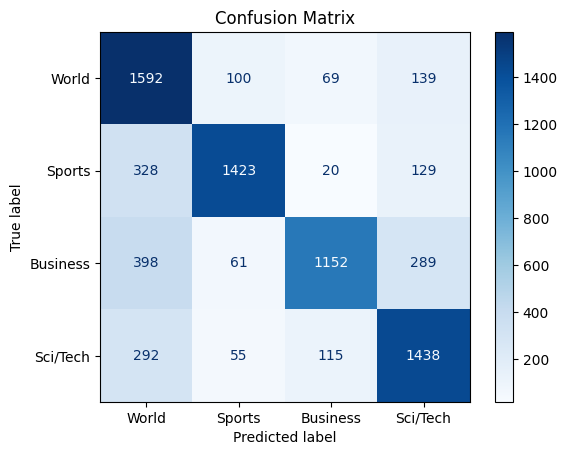

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.84      0.71      1900
           1       0.87      0.75      0.80      1900
           2       0.85      0.61      0.71      1900
           3       0.72      0.76      0.74      1900

    accuracy                           0.74      7600
   macro avg       0.76      0.74      0.74      7600
weighted avg       0.76      0.74      0.74      7600



In [65]:
# Show best KNN Classifier's Results on the Test Set
y_test_pred = best_knn.predict(X_test_reduced)
plot_confusion_matrix(y_test, y_test_pred)
plot_classification_report(y_test, y_test_pred)

#### Sci-kit Learn Implementation

Fitting KNN model with k = 1...
(Test) Accuracy: 0.724
Fitting KNN model with k = 2...
(Test) Accuracy: 0.688
Fitting KNN model with k = 3...
(Test) Accuracy: 0.720
Fitting KNN model with k = 4...
(Test) Accuracy: 0.714
Fitting KNN model with k = 5...
(Test) Accuracy: 0.718
Fitting KNN model with k = 6...
(Test) Accuracy: 0.710
Fitting KNN model with k = 7...
(Test) Accuracy: 0.713
Fitting KNN model with k = 8...
(Test) Accuracy: 0.711
Fitting KNN model with k = 9...
(Test) Accuracy: 0.711
Fitting KNN model with k = 10...
(Test) Accuracy: 0.714

Best k is 1 with accuracy: 0.724


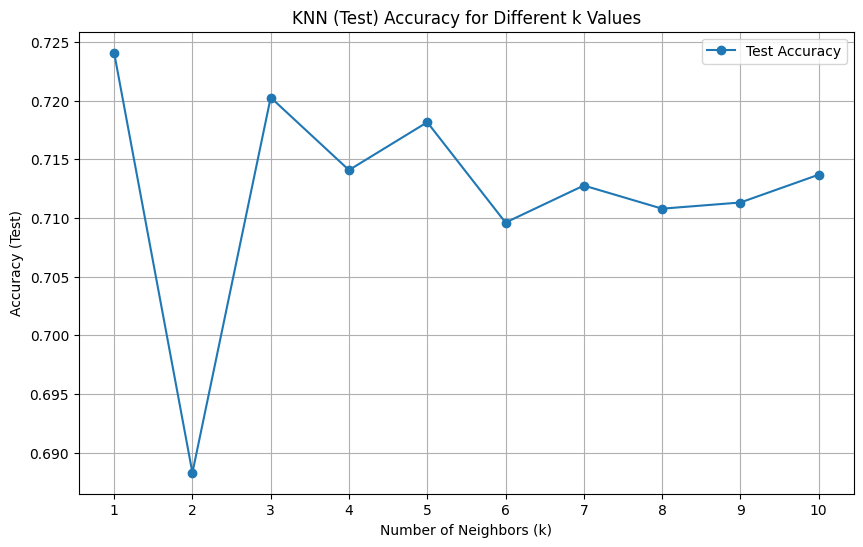

In [66]:
from sklearn.neighbors import KNeighborsClassifier
# Placeholder for accuracies
k_values = range(1, 11)
accuracies = []

# Iterate over values of k
for k in k_values:
    print(f"Fitting KNN model with k = {k}...")

    # Initialize the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the model
    knn.fit(X_train_reduced, y_train_sampled)

    # Predict on the test set
    y_pred = knn.predict(X_test_reduced)

    # Compute accuracy
    accuracy = np.mean(y_pred == y_test)
    accuracies.append(accuracy)
    print(f"(Test) Accuracy: {accuracy:.3f}")

# Find the best k
best = np.argmax(accuracies)
skl_best_k = k_values[best]
print(f"\nBest k is {skl_best_k} with accuracy: {max(accuracies):.3f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', label="Test Accuracy")
plt.title("KNN (Test) Accuracy for Different k Values")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy (Test)")
plt.xticks(k_values)
plt.grid()
plt.legend()
plt.show()

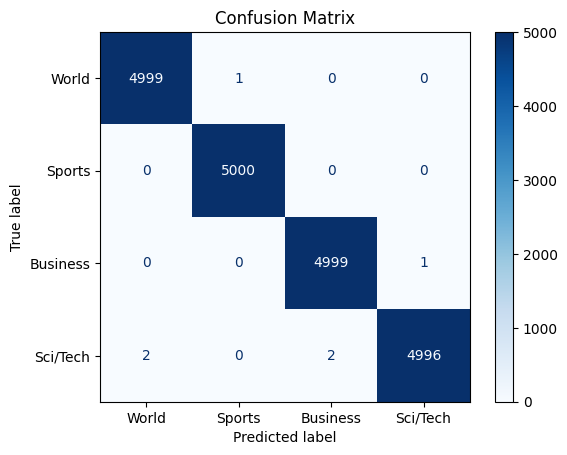

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5000
           1       1.00      1.00      1.00      5000
           2       1.00      1.00      1.00      5000
           3       1.00      1.00      1.00      5000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



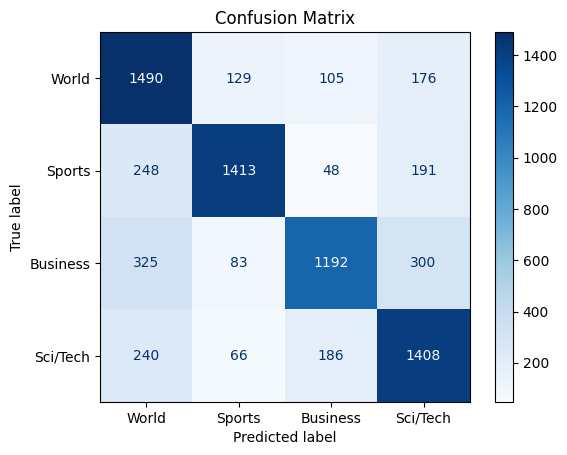

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.78      0.71      1900
           1       0.84      0.74      0.79      1900
           2       0.78      0.63      0.69      1900
           3       0.68      0.74      0.71      1900

    accuracy                           0.72      7600
   macro avg       0.73      0.72      0.72      7600
weighted avg       0.73      0.72      0.72      7600



In [67]:
best_knn_skl = KNeighborsClassifier(n_neighbors=skl_best_k)
best_knn_skl.fit(X_train_reduced, y_train_sampled)
# Show best KNeighborsClassifier's Results on the Training Set
y_train_pred_skl = best_knn_skl.predict(X_train_reduced)
plot_confusion_matrix(y_train_sampled, y_train_pred_skl)
plot_classification_report(y_train_sampled, y_train_pred_skl)
# Show best KNeighborsClassifier's Results on the Test Set
y_test_pred_skl = best_knn_skl.predict(X_test_reduced)
plot_confusion_matrix(y_test, y_test_pred_skl)
plot_classification_report(y_test, y_test_pred_skl)

## Naive Bayes

This implementation demonstrates a Naive Bayes classifier for continuous features, assuming diagonal covariance matrices (i.e., features are conditionally independent given the class).

### Key Concepts

1. **Gaussian Probability Density Function (PDF)**
- Each feature is modeled as following a Gaussian (Normal) distribution:
- The Gaussian PDF is used to compute the likelihood of observing a feature value \(x\) given the class.

2. **Class Priors**
- Class priors represent the probability of each class based on the training data:
- These priors reflect how likely each class is to occur in the dataset.

3. **Conditional Independence Assumption**
- Naive Bayes assumes that all features are independent of one another given the class label:
- This simplifies the computation of the joint probability of the features.

4. **Log-Probability for Numerical Stability**
- To prevent numerical instability from multiplying many small probabilities, Naive Bayes uses logarithms:

- **Reason for Logarithms**:
  - Logarithms transform multiplication into addition.
  - This approach avoids underflow and improves computational stability.

5. **Prediction**
- The class with the highest log-probability is selected as the predicted label:
- This ensures the model predicts the most probable class for a given input.

6. **Diagonal Covariance Assumption**
- The model assumes that each feature has its own variance and is independent of other features:
- This simplifies the computation and parameter estimation, making the model efficient for high-dimensional data.


### Implementation Steps

1. **Define the Gaussian PDF**:
   - This function calculates the likelihood of a feature value given the Gaussian parameters (mean and variance).

2. **Train the Model**:
   - Compute class priors, means, and variances for each class and feature using the training data.

3. **Predict Classes**:
   - Use the trained parameters to compute log-probabilities for each class and predict the class with the highest probability.


In [68]:
# Naive Bayes for Continuous Features with Diagonal Covariance Matrices
def gaussian_probability(x, mean, var):
    """
    Computes the Gaussian probability density function for a given feature.
    Parameters:
        x : numpy.ndarray
            Input feature values.
        mean : float
            Mean of the Gaussian distribution.
        var : float
            Variance of the Gaussian distribution.
    Returns:
        numpy.ndarray
            Probability density values.
    """
    eps = 1e-6  # To avoid division by zero
    coeff = 1.0 / np.sqrt(2.0 * np.pi * (var + eps))
    exponent = np.exp(-((x - mean) ** 2) / (2.0 * (var + eps)))
    return coeff * exponent

def train_naive_bayes(X, Y):
    """
    Trains a Naive Bayes classifier for continuous features.
    Parameters:
        X : numpy.ndarray
            Training data of shape (N, D), where N is the number of samples and D is the number of features.
        Y : numpy.ndarray
            Training labels of shape (N,), where each label is an integer corresponding to a class.
    Returns:
        class_priors : numpy.ndarray
            Prior probabilities for each class.
        class_means : numpy.ndarray
            Mean values for each feature per class.
        class_vars : numpy.ndarray
            Variance values for each feature per class.
    """
    n_samples, n_features = X.shape
    classes = np.unique(Y)
    n_classes = len(classes)

    # Initialize parameters
    class_priors = np.zeros(n_classes)
    class_means = np.zeros((n_classes, n_features))
    class_vars = np.zeros((n_classes, n_features))

    for idx, c in enumerate(classes):
        X_c = X[Y == c]
        class_priors[idx] = X_c.shape[0] / n_samples
        class_means[idx, :] = X_c.mean(axis=0)
        class_vars[idx, :] = X_c.var(axis=0)

    return class_priors, class_means, class_vars

def predict_naive_bayes(X, class_priors, class_means, class_vars):
    """
    Predicts class labels using a trained Naive Bayes classifier.
    Parameters:
        X : numpy.ndarray
            Test data of shape (N, D).
        class_priors : numpy.ndarray
            Prior probabilities for each class.
        class_means : numpy.ndarray
            Mean values for each feature per class.
        class_vars : numpy.ndarray
            Variance values for each feature per class.
    Returns:
        numpy.ndarray
            Predicted class labels for each sample.
    """
    n_samples, n_features = X.shape
    n_classes = class_means.shape[0]

    log_probs = np.zeros((n_samples, n_classes))

    for idx in range(n_classes):
        prior = np.log(class_priors[idx])
        likelihood = np.sum(
            np.log(gaussian_probability(X, class_means[idx], class_vars[idx])), axis=1
        )
        log_probs[:, idx] = prior + likelihood

    return np.argmax(log_probs, axis=1)

In [69]:
# Training Naive Bayes
class_priors, class_means, class_vars = train_naive_bayes(X_train, y_train)
y_train_pred = predict_naive_bayes(X_train, class_priors, class_means, class_vars)

C:\Users\shina\AppData\Local\Temp\ipykernel_384\591098880.py:78: RuntimeWarning: divide by zero encountered in log
  np.log(gaussian_probability(X, class_means[idx], class_vars[idx])), axis=1


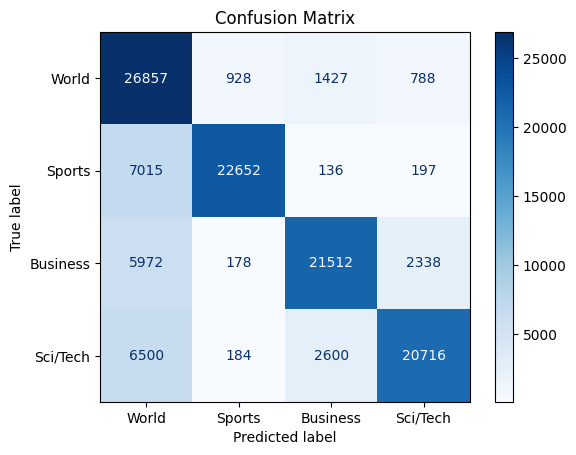

In [70]:
plot_confusion_matrix(y_train, y_train_pred)

In [71]:
plot_classification_report(y_train, y_train_pred)

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.90      0.70     30000
           1       0.95      0.76      0.84     30000
           2       0.84      0.72      0.77     30000
           3       0.86      0.69      0.77     30000

    accuracy                           0.76    120000
   macro avg       0.81      0.76      0.77    120000
weighted avg       0.81      0.76      0.77    120000



In [72]:
# Predicting on test set
y_test_pred = predict_naive_bayes(X_test, class_priors, class_means, class_vars)

C:\Users\shina\AppData\Local\Temp\ipykernel_384\591098880.py:78: RuntimeWarning: divide by zero encountered in log
  np.log(gaussian_probability(X, class_means[idx], class_vars[idx])), axis=1


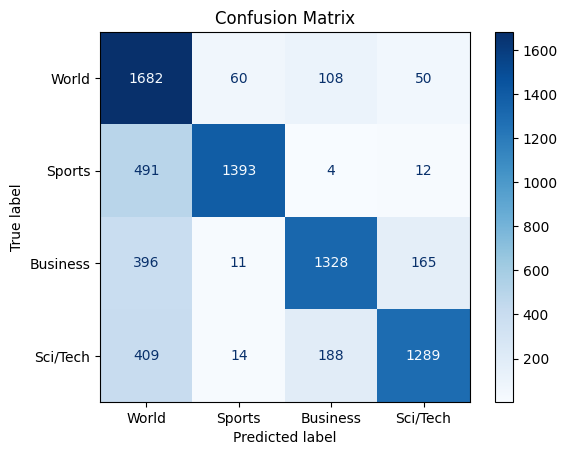

In [73]:
plot_confusion_matrix(y_test, y_test_pred)

In [74]:
plot_classification_report(y_test, y_test_pred)

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.89      0.69      1900
           1       0.94      0.73      0.82      1900
           2       0.82      0.70      0.75      1900
           3       0.85      0.68      0.75      1900

    accuracy                           0.75      7600
   macro avg       0.79      0.75      0.76      7600
weighted avg       0.79      0.75      0.76      7600



#### Sci-kit Learn Implementation

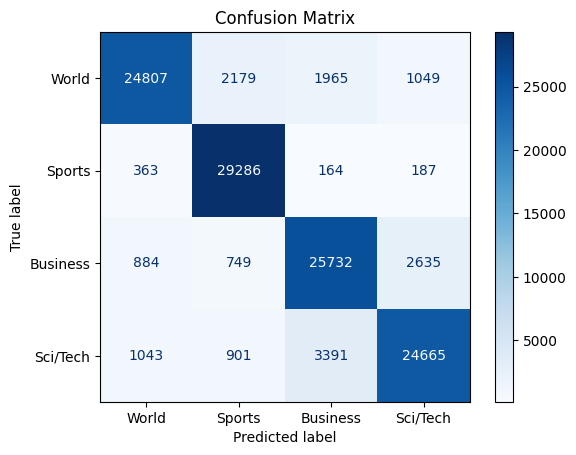

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87     30000
           1       0.88      0.98      0.93     30000
           2       0.82      0.86      0.84     30000
           3       0.86      0.82      0.84     30000

    accuracy                           0.87    120000
   macro avg       0.87      0.87      0.87    120000
weighted avg       0.87      0.87      0.87    120000



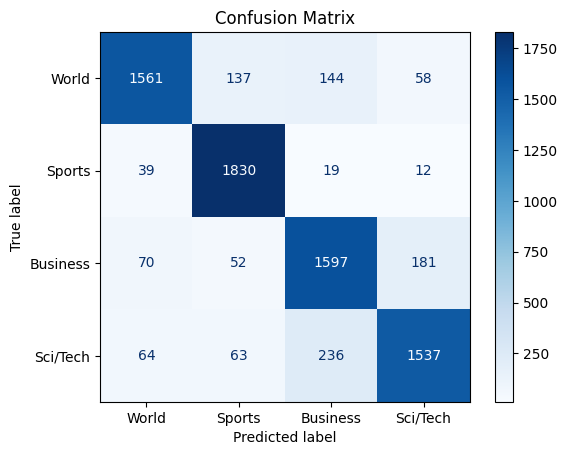

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      1900
           1       0.88      0.96      0.92      1900
           2       0.80      0.84      0.82      1900
           3       0.86      0.81      0.83      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600



In [75]:
from sklearn.naive_bayes import GaussianNB
# Initialize Gaussian Naive Bayes
gnb_classifier = GaussianNB()
# Train Naive Bayes classifier
gnb_classifier.fit(X_train, y_train)
# Predict on training data
y_train_pred_skl = gnb_classifier.predict(X_train)
plot_confusion_matrix(y_train, y_train_pred_skl)
plot_classification_report(y_train, y_train_pred_skl)
# Predict on test set
y_test_pred_skl = gnb_classifier.predict(X_test)
plot_confusion_matrix(y_test, y_test_pred_skl)
plot_classification_report(y_test, y_test_pred_skl)

## MLP (Multi-Layer Perceptron)

Our workflow for multi-class text classification using an MLP includes:

1. **Text Data Encoding**:
   - Utilizes a FastText model to create word embeddings for the text data.
   - Encodes the embeddings into dense vectors, which are used as inputs to the neural network.

2. **Custom Dataset and DataLoader**:
   - A `TextDataset` class is created to handle the input data and corresponding labels.
   - `DataLoader` is used to efficiently batch and shuffle the data during training and testing.

3. **Model Definition**:
   - The `MLP` class defines a flexible neural network with user-specified hidden layers and activation functions.
   - Includes options to customize the number of hidden layers and layer dimensions.

4. **Training Pipeline**:
   - **Loss function**: *Cross-Entropy Loss* is used.
   - **Optimization**: *Stochastic Gradient Descent (SGD)* is used with momentum to optimize the network parameters.
   - **Early Stopping**: Prevents overfitting by halting training if validation loss does not improve after a set number of epochs.

5. **Evaluation and Visualization**:
   - Evaluation functions compute the accuracy of the model on training and test datasets.
   - Confusion matrices and classification reports provide detailed insights into model performance.
   - A loss curve is plotted to visualize training progress over epochs.

6. **Key Results**:
   - The trained MLP is evaluated on both training and test datasets to measure accuracy and other performance metrics.

In [33]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module, Linear, ReLU, CrossEntropyLoss
from torch.optim import SGD
from gensim.models import FastText
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [34]:
# Train FastText model ~4 minutes for all the data
fasttext_model = FastText(sentences=[text.split() for text in train_texts], vector_size=100, window=5, min_count=1, workers=os.cpu_count(), sg=1)

In [35]:
# Encode text data into embeddings
def encode_texts_with_fasttext(texts):
    embeddings = []
    for text in texts:
        words = text.split()
        word_embeddings = [fasttext_model.wv[word] for word in words if word in fasttext_model.wv]
        if word_embeddings:
            embeddings.append(np.mean(word_embeddings, axis=0))
        else:
            embeddings.append(np.zeros(fasttext_model.vector_size))
    return np.array(embeddings)

train_embeddings = encode_texts_with_fasttext(train_texts)
test_embeddings = encode_texts_with_fasttext(test_texts)

# Encode labels
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

In [36]:
train_embeddings = encode_texts_with_fasttext(train_texts)
test_embeddings = encode_texts_with_fasttext(test_texts)

# Encode labels
train_labels = train_labels.clone().detach().long()
test_labels = test_labels.clone().detach().long()

In [42]:
# Create custom Dataset class
class TextDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [43]:
train_dataset = TextDataset(train_embeddings, train_labels)
test_dataset = TextDataset(test_embeddings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [44]:
# Define the MLP model
class MLP(Module):
    def __init__(self, input_dim, output_dim, hidden_layers, activation_fn=ReLU):
        super(MLP, self).__init__()
        layers = []
        current_dim = input_dim

        # Add hidden layers
        for hidden_dim in hidden_layers:
            layers.append(Linear(current_dim, hidden_dim))
            layers.append(activation_fn())
            current_dim = hidden_dim

        # Add the final output layer
        layers.append(Linear(current_dim, output_dim))

        # Combine layers into a sequential module
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [45]:
# Instantiate the model
def create_mlp_model(input_dim, output_dim, hidden_layers):
    return MLP(input_dim=input_dim, output_dim=output_dim, hidden_layers=hidden_layers)

input_dim = train_embeddings.shape[1]
num_classes = len(set(train_labels.numpy()))
hidden_layers = [128, 64] # Dimensions for each of the hidden layers
mlp_model = create_mlp_model(input_dim=input_dim, output_dim=num_classes, hidden_layers=hidden_layers)

In [46]:
# Define loss function and optimizer
criterion = CrossEntropyLoss()
optimizer = SGD(mlp_model.parameters(), lr=0.01, momentum=0.9)

In [47]:
# Early stopping class
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None

    def should_stop(self, loss):
        if self.best_loss is None or loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

In [103]:
# Early stopper instance
early_stopper = EarlyStopper(patience=5, min_delta=0.001)

In [104]:
# Plot loss curve
def plot_loss_curve(loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.grid()
    plt.show()

In [115]:
import random
def set_seed(random_state):
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    np.random.seed(random_state)
    random.seed(random_state)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [116]:
# Training loop with early stopping and loss tracking
def train_model(model, dataloader, criterion, optimizer, epochs=20, early_stopper=None, random_state=42):
    if random_state is not None:
        set_seed(random_state)
    model = model.to("cuda")
    loss_history = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")
        if early_stopper and early_stopper.should_stop(avg_loss):
            print("Early stopping triggered.")
            break
    return loss_history

In [117]:
# Train the model
loss_history = train_model(mlp_model, train_loader, criterion, optimizer, epochs=30, early_stopper=early_stopper, random_state=42)

Epoch [1/30], Loss: 0.1574
Epoch [2/30], Loss: 0.1563
Epoch [3/30], Loss: 0.1568
Epoch [4/30], Loss: 0.1562
Epoch [5/30], Loss: 0.1562
Epoch [6/30], Loss: 0.1539
Epoch [7/30], Loss: 0.1537
Epoch [8/30], Loss: 0.1533
Epoch [9/30], Loss: 0.1521
Epoch [10/30], Loss: 0.1535
Epoch [11/30], Loss: 0.1514
Epoch [12/30], Loss: 0.1512
Epoch [13/30], Loss: 0.1512
Epoch [14/30], Loss: 0.1508
Epoch [15/30], Loss: 0.1497
Epoch [16/30], Loss: 0.1484
Epoch [17/30], Loss: 0.1484
Epoch [18/30], Loss: 0.1471
Epoch [19/30], Loss: 0.1476
Epoch [20/30], Loss: 0.1469
Epoch [21/30], Loss: 0.1455
Epoch [22/30], Loss: 0.1456
Epoch [23/30], Loss: 0.1452
Epoch [24/30], Loss: 0.1439
Epoch [25/30], Loss: 0.1442
Epoch [26/30], Loss: 0.1426
Epoch [27/30], Loss: 0.1444
Epoch [28/30], Loss: 0.1433
Epoch [29/30], Loss: 0.1426
Epoch [30/30], Loss: 0.1422


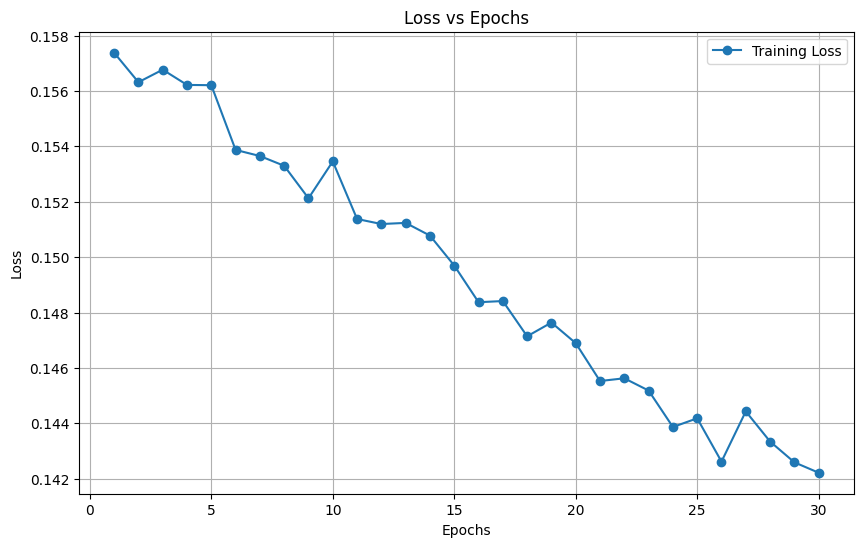

In [118]:
plot_loss_curve(loss_history)

In [119]:
# Evaluation loop
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to("cuda"), labels.to("cuda")
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")
    return y_true, y_pred

In [120]:
y_train_true, y_train_pred = evaluate_model(mlp_model, train_loader)

Accuracy: 94.52%


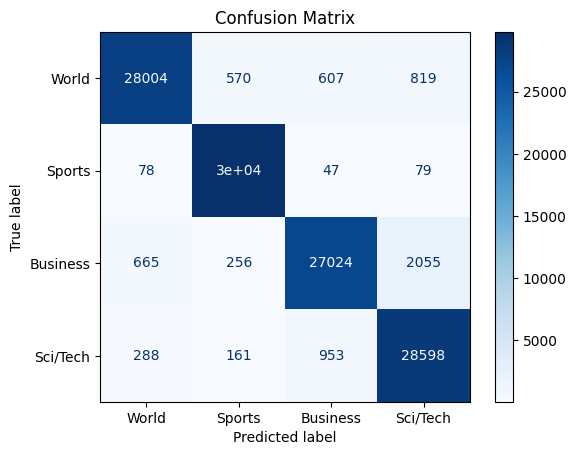

In [121]:
plot_confusion_matrix(y_train_true, y_train_pred)

In [122]:
plot_classification_report(y_train_true, y_train_pred)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95     30000
           1       0.97      0.99      0.98     30000
           2       0.94      0.90      0.92     30000
           3       0.91      0.95      0.93     30000

    accuracy                           0.95    120000
   macro avg       0.95      0.95      0.95    120000
weighted avg       0.95      0.95      0.95    120000



In [123]:
# Evaluate the model
y_test_true, y_test_pred = evaluate_model(mlp_model, test_loader)

Accuracy: 90.51%


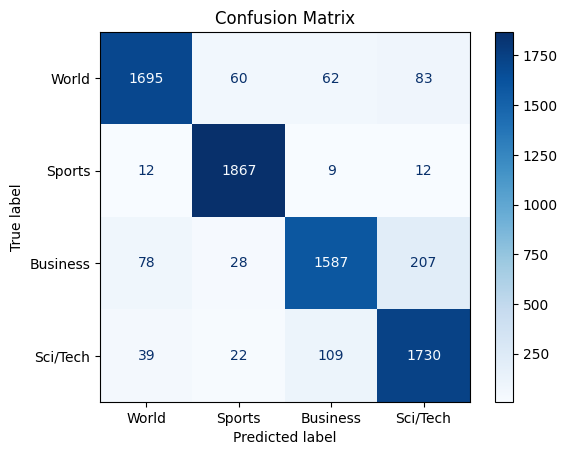

In [124]:
plot_confusion_matrix(y_test_true, y_test_pred)

In [125]:
plot_classification_report(y_test_true, y_test_pred)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1900
           1       0.94      0.98      0.96      1900
           2       0.90      0.84      0.87      1900
           3       0.85      0.91      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.90      7600
weighted avg       0.91      0.91      0.90      7600



#### Sci-kit learn Implementation

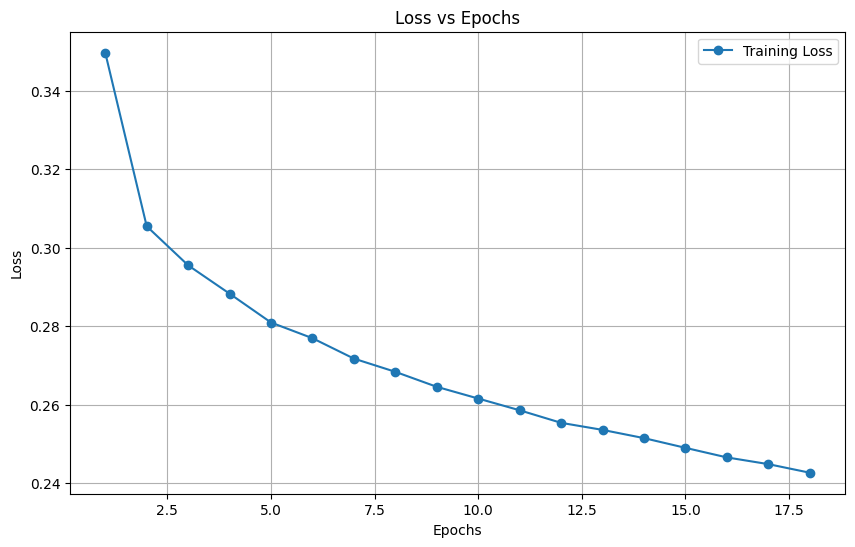

In [101]:
from sklearn.neural_network import MLPClassifier
# Define and train the scikit-learn MLPClassifier
sklearn_mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64), # Match hidden layers to PyTorch model
    batch_size=32,                # Batch size for SGD
    activation='relu',            # Use ReLU activation
    solver='sgd',                 # Stochastic Gradient Descent
    learning_rate_init=0.01,      # Starting learning rate
    max_iter=30,                  # Epochs
    early_stopping=True,          # Enable early stopping
    n_iter_no_change=5,           # Stop training if validation loss doesn't improve in 3 epochs
    tol=0.001,                    # Tolerance for early stopping
    random_state=42
)

# Fit the scikit-learn MLP model
sklearn_mlp.fit(train_embeddings, train_labels)
# Plot loss curve
plot_loss_curve(sklearn_mlp.loss_curve_)

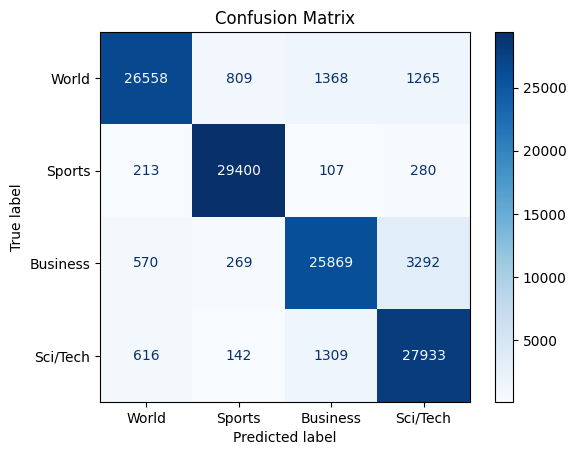

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     30000
           1       0.96      0.98      0.97     30000
           2       0.90      0.86      0.88     30000
           3       0.85      0.93      0.89     30000

    accuracy                           0.91    120000
   macro avg       0.92      0.91      0.91    120000
weighted avg       0.92      0.91      0.91    120000



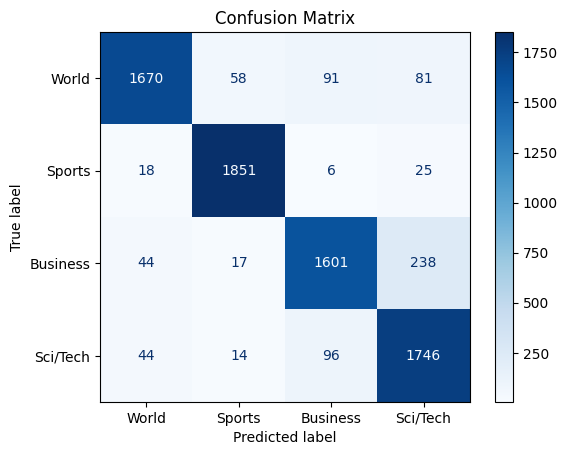

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1900
           1       0.95      0.97      0.96      1900
           2       0.89      0.84      0.87      1900
           3       0.84      0.92      0.88      1900

    accuracy                           0.90      7600
   macro avg       0.91      0.90      0.90      7600
weighted avg       0.91      0.90      0.90      7600



In [102]:
# Predict with the scikit-learn MLP model on the training data
y_train_pred_sklearn = sklearn_mlp.predict(train_embeddings)
plot_confusion_matrix(train_labels, y_train_pred_sklearn)
plot_classification_report(train_labels, y_train_pred_sklearn)

# Predict with the scikit-learn MLP model on the test data
y_test_pred_sklearn = sklearn_mlp.predict(test_embeddings)
plot_confusion_matrix(test_labels, y_test_pred_sklearn)
plot_classification_report(test_labels, y_test_pred_sklearn)

## SVM (Support Vector Machine) with One-vs-Rest Strategy

The implementation of a custom Support Vector Machine (SVM) classifier and its application to multi-class text classification using the One-vs-Rest (OvR) strategy include:

1. **Custom SVM Classifier**:
   - **Initialization**: Allows configuration of regularization strength (`C`), `learning rate`, and the `number of iterations` for optimization.
   - **Training (`fit` method)**:
     - Implements gradient descent to minimize the hinge loss function.
     - Incorporates L2 regularization to prevent overfitting.
   - **Prediction (`predict` method)**:
     - Computes the raw decision values for new data points.

2. **One-vs-Rest Strategy**:
   - For each class, a binary SVM classifier is trained to distinguish the current class (positive) from all other classes (negative).
   - The training process generates a separate classifier for each class.

3. **Multi-class Prediction**:
   - During prediction, decision scores are calculated for all classifiers.
   - The class with the highest decision score is assigned as the predicted label for each sample.

4. **Performance Evaluation**:
   - Accuracy is assessed using confusion matrices and classification reports.


In [76]:
class SVM:
    def __init__(self, C=1000.0, learning_rate=0.01, max_iter=2000):
        self.C = C  # Regularization strength
        self.learning_rate = learning_rate # Step size for gradient descent updates
        self.max_iter = max_iter # Maximum number of iterations for the optimization

    def fit(self, X, y):
        """Train the SVM classifier using gradient descent optimization.
        
        Implements the soft-margin SVM optimization using gradient descent with hinge loss.
        Updates the model's weights and bias to find the optimal separating hyperplane
        that maximizes the margin while allowing for some misclassification errors.
        
        Args:
            X (numpy.ndarray): Training data of shape (n_samples, n_features)
            y (numpy.ndarray): Target labels of shape (n_samples,) -> Expected to be binary labels (-1, 1)
        
        Returns:
            self: The fitted classifier instance
        """
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient Descent
        for _ in range(self.max_iter):
            for idx, x_i in enumerate(X):
                # Compute the margin
                margin = y[idx] * (np.dot(x_i, self.weights) + self.bias)

                # Update weights and bias
                if margin >= 1:
                    # No hinge loss; apply only regularization gradient
                    self.weights -= self.learning_rate * (2 * self.weights / self.C)
                else:
                    # Hinge loss; apply both regularization and hinge gradient
                    self.weights -= self.learning_rate * (2 * self.weights / self.C - np.dot(x_i, y[idx]))
                    self.bias -= self.learning_rate * y[idx]

    def predict(self, X):
        """Predict class labels for samples in X.
        
        Computes the decision function f(x) = w^T x + b for each sample.
        The sign of this value determines the predicted class.
        
        Args:
            X (numpy.ndarray): Input samples of shape (n_samples, n_features)
        
        Returns:
            numpy.ndarray: Decision function values for each sample.
                          Positive values indicate class 1, negative values indicate class -1.
        """
        # Return raw decision values (used for one-vs-rest scoring)
        return np.dot(X, self.weights) + self.bias

### One vs. Rest Strategy

In [77]:
# One-vs-Rest Training
from sklearn.svm import SVC
from sklearn.svm import SVC
def train_ovr_svm(X, y, num_classes, custom=True):
    """
    Train multiple SVM classifiers using the One-vs-Rest (OvR) strategy for multi-class classification.

    Parameters:
    -----------
    X : numpy.ndarray of shape (n_samples, n_features)
        Training data. Each row represents a sample, and each column represents a feature.

    y : numpy.ndarray of shape (n_samples,)
        Target labels. Should contain integer labels from 0 to num_classes-1.

    num_classes : int
        Number of unique classes in the dataset.

    Returns:
    --------
    classifiers : list
        List of trained SVM classifiers, one for each class.
        Each classifier is trained to distinguish one class from all others.
        Length of list equals num_classes.

    Notes:
    ------
    - Uses One-vs-Rest strategy where for each class c, a binary classifier is trained
      to distinguish class c (positive label 1) from all other classes (negative label -1)
    - Each classifier is an instance of the SVM class with default parameters:
        - C=1.0 (regularization parameter)
        - learning_rate=0.01
        - max_iter=1000
    """
    classifiers = []
    if custom:
        # Custom SVM implementation
        for c in range(num_classes):
            # Convert to binary problem: current class (1) vs all other classes (-1)
            y_binary = np.where(y == c, 1, -1)
            # Initialize and train SVM classifier for the current class
            clf = SVM() # Default hyper-parameter values: C=100.0, learning_rate=0.001, max_iter=1000
            clf.fit(X, y_binary)
            classifiers.append(clf)
    else:
        # Scikit-learn SVM implementation
        for c in range(num_classes):
            # Convert to binary problem: current class (1) vs all other classes (-1)
            y_binary = np.where(y == c, 1, -1)
            # Initialize and train SVM classifier for the current class
            clf = SGDClassifier(loss='hinge', alpha=1 / (2 * 1000.0), penalty="l2", learning_rate='constant', eta0=0.01, max_iter=2000, tol=None, random_state=42)
            clf.fit(X, y_binary)
            classifiers.append(clf)
    return classifiers

In [78]:
# One-vs-Rest Prediction
def predict_ovr_svm(X, classifiers):
    """
    Predict class labels for samples in X using trained One-vs-Rest SVM classifiers.

    Parameters:
    -----------
    X : numpy.ndarray of shape (n_samples, n_features)
        Test samples to predict. Each row represents a sample, and each column
        represents a feature.

    classifiers : list
        List of trained SVM classifiers from train_ovr_svm function.
        Each classifier corresponds to one class and predicts whether a sample
        belongs to that class or not.

    Returns:
    --------
    predictions : numpy.ndarray of shape (n_samples,)
        Predicted class labels for each sample in X.
        Labels are integers from 0 to (num_classes-1).

    Notes:
    ------
    - For each sample, gets prediction scores from all classifiers.
    - Assigns the class label based on the classifier that produced the highest score.
    - The shape of intermediate scores array is (n_samples, num_classes)
    - Uses argmax to select the class with highest confidence score for each sample
    """
    # Get predictions from all classifiers
    scores = [clf.predict(X) for clf in classifiers]
    # Convert to array and transpose to shape (n_samples, num_classes)
    scores = np.array(scores).T
    # Return class with highest score for each sample
    return np.argmax(scores, axis=1)

In [79]:
svm_classifiers = train_ovr_svm(X_train_scaled, y_train_sampled, len(set(y_train_sampled)))

In [80]:
print(len(svm_classifiers)) # should be 4, same as the number of classes

4


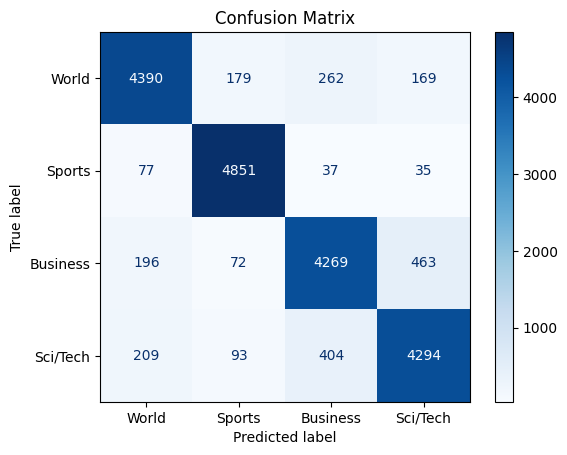

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.93      0.97      0.95      5000
           2       0.86      0.85      0.86      5000
           3       0.87      0.86      0.86      5000

    accuracy                           0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000



In [81]:
y_train_pred_ovr_svm = predict_ovr_svm(X_train_scaled, svm_classifiers)
plot_confusion_matrix(y_train_sampled, y_train_pred_ovr_svm)
plot_classification_report(y_train_sampled, y_train_pred_ovr_svm)

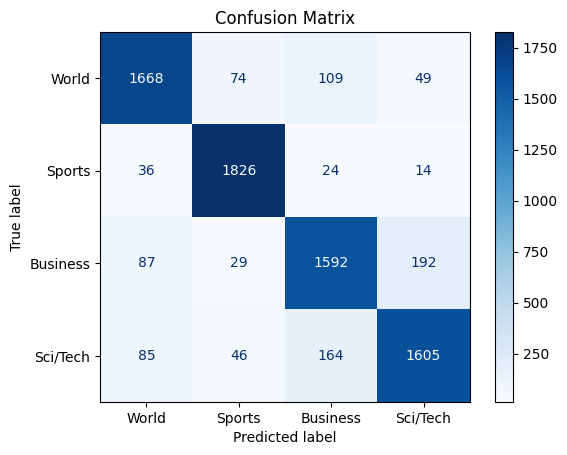

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1900
           1       0.92      0.96      0.94      1900
           2       0.84      0.84      0.84      1900
           3       0.86      0.84      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600



In [82]:
y_test_pred_ovr_svm = predict_ovr_svm(X_test_scaled, svm_classifiers)
plot_confusion_matrix(y_test, y_test_pred_ovr_svm)
plot_classification_report(y_test, y_test_pred_ovr_svm)

#### Sci-kit Learn Implementation

4


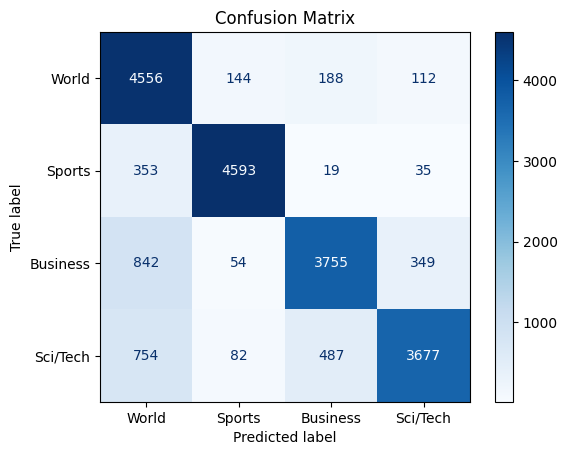

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.91      0.79      5000
           1       0.94      0.92      0.93      5000
           2       0.84      0.75      0.79      5000
           3       0.88      0.74      0.80      5000

    accuracy                           0.83     20000
   macro avg       0.84      0.83      0.83     20000
weighted avg       0.84      0.83      0.83     20000



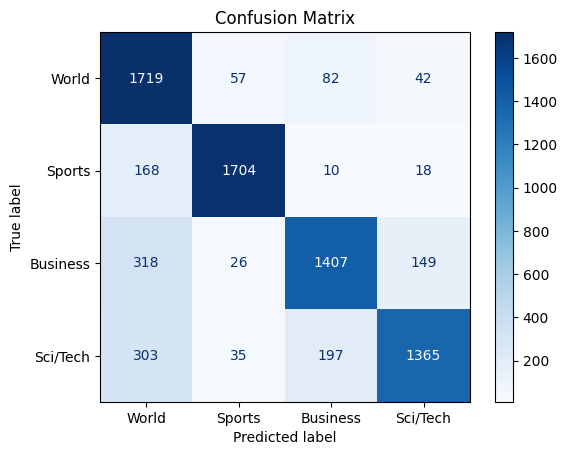

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.90      0.78      1900
           1       0.94      0.90      0.92      1900
           2       0.83      0.74      0.78      1900
           3       0.87      0.72      0.79      1900

    accuracy                           0.82      7600
   macro avg       0.83      0.82      0.82      7600
weighted avg       0.83      0.82      0.82      7600



In [83]:
# Fitting the SVM Classifiers
svm_classifiers_skl = train_ovr_svm(X_train_scaled, y_train_sampled, len(set(y_train_sampled)), custom=False)
print(len(svm_classifiers_skl)) # should be 4, same as the number of classes
# Predicting on the training data
y_train_pred_ovr_svm = predict_ovr_svm(X_train_scaled, svm_classifiers_skl)
plot_confusion_matrix(y_train_sampled, y_train_pred_ovr_svm)
plot_classification_report(y_train_sampled, y_train_pred_ovr_svm)
# Predicting on the test data
y_test_pred_ovr_svm = predict_ovr_svm(X_test_scaled, svm_classifiers_skl)
plot_confusion_matrix(y_test, y_test_pred_ovr_svm)
plot_classification_report(y_test, y_test_pred_ovr_svm)

## K Means

**Key Concepts of the KMeansClassifier Implementation**

This custom implementation of the K-Means algorithm introduces several key concepts that enhance its functionality and make it versatile for clustering tasks:

**1. Clustering**
- **K-Means Clustering**:
  - A clustering algorithm that partitions data into `k` clusters.
  - Assigns each data point to the nearest cluster center (centroid).
  - Updates centroids as the mean of all points in a cluster.

**2. K-Means++ Initialization**
- Improves traditional K-Means initialization by selecting centroids strategically.
- Ensures centroids are spread out, reducing the chances of poor clustering and speeding up convergence.
- Selects the first centroid randomly, and subsequent centroids are chosen based on their distance from existing centroids.

**3. Distance Metrics**
- **Euclidean Distance**:
  - Measures the straight-line distance between points in a feature space.
  - Suitable for spherical clusters.

- **Cosine Similarity**:
  - Measures the angle between two vectors, focusing on their orientation rather than magnitude.
  - Useful for high-dimensional or sparse data (e.g., text data).

**4. Centroid Update**
- Centroids are recalculated in each iteration as the mean of all data points assigned to the cluster.
- Ensures centroids represent the center of their respective clusters.
- Handles cases where clusters are empty by reinitializing those centroids.

**5. Weighted Voting for Label Assignment**
- Maps clusters to true labels using a weighted voting mechanism:
  - Points closer to the centroid have higher influence on the assigned label.
  - Ensures clusters align better with the ground-truth labels if provided.
- Allows semi-supervised use of K-Means when true labels are available during training.

**6. Convergence**
- The algorithm stops when:
  - Centroids move less than a specified tolerance (`tol`).
  - The maximum number of iterations (`max_iter`) is reached.
- Convergence ensures the algorithm finds stable clusters.

**7. Predicting Cluster Labels**
- Predicts the cluster for new data points based on the nearest centroid.
- Optionally maps clusters to true labels if they were provided during training.

**8. Handling Empty Clusters**
- If no points are assigned to a cluster during training, the algorithm reinitializes that cluster's centroid.
- Prevents the algorithm from failing due to missing cluster assignments.

**9. Flexibility**
- The implementation supports:
  - Customizable number of clusters (`n_clusters`).
  - Choice of distance metric (`euclidean` or `cosine`).
  - Adjustable convergence tolerance (`tol`) and maximum iterations (`max_iter`).
  - Reproducibility through a random seed (`random_state`).

**10. Application**
- Suitable for unsupervised clustering tasks (e.g., customer segmentation, image segmentation).
- Can be used for semi-supervised learning by mapping clusters to labels.
- Adaptable for different data types (numerical, text, etc.) through feature engineering.

In [95]:
from collections import Counter
class KMeansClassifier:
    def __init__(self, n_clusters=4, max_iter=300, tol=1e-4, distance_metric='euclidean', random_state=None):
        self.n_clusters = n_clusters # Number of clusters to form
        self.max_iter = max_iter # Maximum number of iterations for the algorithm
        self.tol = tol # Tolerance for centroid convergence
        self.distance_metric = distance_metric # Distance metric to use ('euclidean' or 'cosine')
        self.random_state = random_state 
        self.centroids = None
        self.cluster_labels = None

    def _initialize_centroids(self, X):
        """Initialize cluster centroids using the k-means++ algorithm.
        
        This method implements the k-means++ initialization strategy, which selects initial
        centroids with probability proportional to their distance from previously selected
        centroids. This approach helps avoid poor initialization that can occur with
        random selection.
        
        Args:
            X (numpy.ndarray): Input data of shape (n_samples, n_features)
            
        Returns:
            numpy.ndarray: Initial centroids of shape (n_clusters, n_features)
        """
        np.random.seed(self.random_state)
        centroids = [X[np.random.choice(X.shape[0])]]
        for _ in range(1, self.n_clusters):
            distances = np.min(np.linalg.norm(X[:, np.newaxis] - np.array(centroids), axis=2), axis=1)
            probs = distances / distances.sum()
            probs[np.isnan(probs)] = 1 / len(probs)
            next_centroid = X[np.random.choice(X.shape[0], p=probs)]
            centroids.append(next_centroid)
        return np.array(centroids)

    def _compute_distances(self, X):
        """Computes distances between data points and centroids using specified metric.
        
        This function supports two distance metrics:
        
        1. Euclidean Distance:
           Recommended when:
           - The absolute magnitudes of the features matter
           - The data points are in a meaningful coordinate space
           - The features are measured in the same units
           
        2. Cosine Distance:
           Recommended when:
           - Only the direction/angle between vectors matters, not their magnitude
           - Dealing with high-dimensional sparse data (like text vectors in our case)
           - Features have different scales or units
           - Want to capture semantic similarity rather than absolute distances
           
        Args:
            X (numpy.ndarray): Input data points of shape (n_samples, n_features)
            
        Returns:
            numpy.ndarray: Distance matrix of shape (n_samples, n_clusters)
            
        Raises:
            ValueError: If distance_metric is not 'euclidean' or 'cosine'
        """
        if self.distance_metric == 'euclidean':
            return np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        elif self.distance_metric == 'cosine':
            norm_X = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-6)
            norm_centroids = self.centroids / (np.linalg.norm(self.centroids, axis=1, keepdims=True) + 1e-6)
            # Covert similarity to distance: distance = 1 - similarity
            return 1 - np.dot(norm_X, norm_centroids.T)
        else:
            raise ValueError("Unsupported distance metric. Use 'euclidean' or 'cosine'.")

    def fit(self, X, y=None):
        """Fit the K-means model to the input data.
        
        Performs the main K-means clustering algorithm, iteratively assigning points
        to clusters and updating centroids until convergence. If labels (y) are provided,
        performs additional refinement to assign meaningful labels to clusters.
        
        Args:
            X (numpy.ndarray): Training data of shape (n_samples, n_features)
            y (numpy.ndarray, optional): Target labels for supervised refinement
            
        Returns:
            self: The fitted classifier instance
        """
        self.centroids = self._initialize_centroids(X)
        for _ in range(self.max_iter):
            distances = self._compute_distances(X)
            clusters = np.argmin(distances, axis=1)
            new_centroids = np.array([
                X[clusters == k].mean(axis=0) if np.any(clusters == k) else X[np.random.choice(X.shape[0])]
                for k in range(self.n_clusters)
            ])
            if np.all(np.linalg.norm(self.centroids - new_centroids, axis=1) < self.tol):
                break
            self.centroids = new_centroids
        if y is not None:
            self.cluster_labels = self._refined_assign_labels(X, y, clusters)
        else:
            self.cluster_labels = {k: k for k in range(self.n_clusters)}  # Default to cluster indices

    def predict(self, X):
        """Predict cluster labels for input samples.
        
        Assigns each input sample to the nearest cluster based on the distance metric
        and returns the corresponding cluster labels.
        
        Args:
            X (numpy.ndarray): Input samples of shape (n_samples, n_features)
            
        Returns:
            numpy.ndarray: Predicted cluster labels for each sample
        """
        distances = self._compute_distances(X)
        clusters = np.argmin(distances, axis=1)
        return np.array([self.cluster_labels.get(cluster, -1) for cluster in clusters])

    def _refined_assign_labels(self, X, y, clusters): # We can do this because we have a labeled dataset.
        """Assign meaningful labels to clusters based on the true labels of their points.
        
        For each cluster, computes a weighted vote of the true labels of its points,
        where the weight of each point is inversely proportional to its distance from
        the cluster centroid. This helps assign more meaningful labels to clusters
        when ground truth labels are available.
        
        Args:
            X (numpy.ndarray): Input data points
            y (numpy.ndarray): True labels for input points
            clusters (numpy.ndarray): Cluster assignments for each point
            
        Returns:
            dict: Mapping from cluster indices to assigned labels
        """
        cluster_labels = {}
        for k in range(len(self.centroids)):
            cluster_indices = np.where(clusters == k)[0]
            cluster_points = y[cluster_indices]
            distances = np.linalg.norm(X[cluster_indices] - self.centroids[k], axis=1)
            weighted_counts = Counter()
            for i, label in enumerate(cluster_points):
                weighted_counts[label] += min(1 / (distances[i] + 1e-5), 1e5)
            if len(weighted_counts) > 0:
                cluster_labels[k] = max(weighted_counts, key=weighted_counts.get)
            else:
                cluster_labels[k] = -1  # Default for undefined clusters
        return cluster_labels

##### Application of Custom K-Means Classifier to Iris Dataset (to validate that it is correct)

Cluster-to-Label Mapping: {0: np.int64(0), 1: np.int64(1), 2: np.int64(2)}
Training Confusion Matrix:


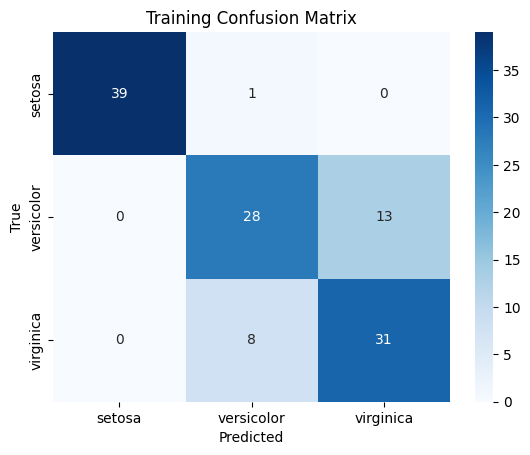

Training Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      0.97      0.99        40
  versicolor       0.76      0.68      0.72        41
   virginica       0.70      0.79      0.75        39

    accuracy                           0.82       120
   macro avg       0.82      0.82      0.82       120
weighted avg       0.82      0.82      0.82       120

Testing Confusion Matrix:


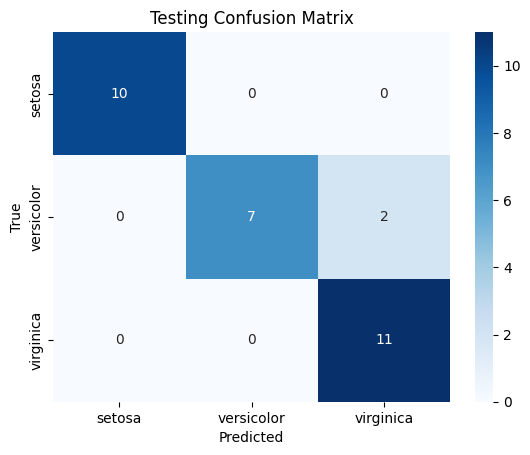

Testing Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.78      0.88         9
   virginica       0.85      1.00      0.92        11

    accuracy                           0.93        30
   macro avg       0.95      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



In [96]:
# Import the Iris dataset and preprocess
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target  # Features and labels

# Normalize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the KMeans model
kmeans_iris = KMeansClassifier(n_clusters=3, random_state=42, distance_metric='euclidean')
kmeans_iris.fit(X_train_iris, y_train_iris)  # Use the training data and true labels for refined assignment

# Get cluster centers and cluster-label mapping
centers = kmeans_iris.centroids
labels = kmeans_iris.cluster_labels
print("Cluster-to-Label Mapping:", labels)

# Predict clusters for training data
kmeans_train_predictions = kmeans_iris.predict(X_train_iris)

# Evaluate on training data
print("Training Confusion Matrix:")
conf_matrix = confusion_matrix(y_train_iris, kmeans_train_predictions)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.title("Training Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Training Classification Report:")
print(classification_report(y_train_iris, kmeans_train_predictions, target_names=iris.target_names))

# Predict clusters for testing data
kmeans_test_predictions = kmeans_iris.predict(X_test_iris)

# Evaluate on testing data
print("Testing Confusion Matrix:")
conf_matrix = confusion_matrix(y_test_iris, kmeans_test_predictions)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.title("Testing Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Testing Classification Report:")
print(classification_report(y_test_iris, kmeans_test_predictions, target_names=iris.target_names))

# Visualize cluster centers (only if reduced to 2D)
if centers.shape[1] == 2:
    plt.scatter(centers[:, 0], centers[:, 1], marker='x', s=200, linewidths=3, color='r', label='Cluster Centers')
    plt.legend()
    plt.title("Cluster Centers")
    plt.show()

#### Application of the custom K-Means for clustering of our news dataset

In [97]:
kmeans = KMeansClassifier(n_clusters=4, random_state=42, distance_metric='euclidean')
kmeans.fit(X_train_scaled, y_train_sampled)
centers = kmeans.centroids
labels = kmeans.cluster_labels

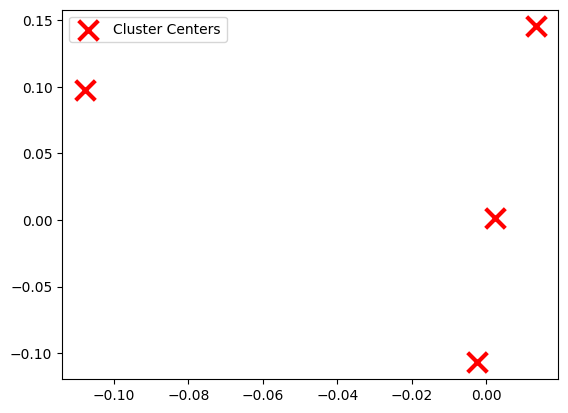

In [98]:
# Plot cluster centers with labels
plt.scatter(centers[:, 0], centers[:, 1], marker='x', s=200, linewidths=3, color='r', label='Cluster Centers')
plt.legend()
plt.show()

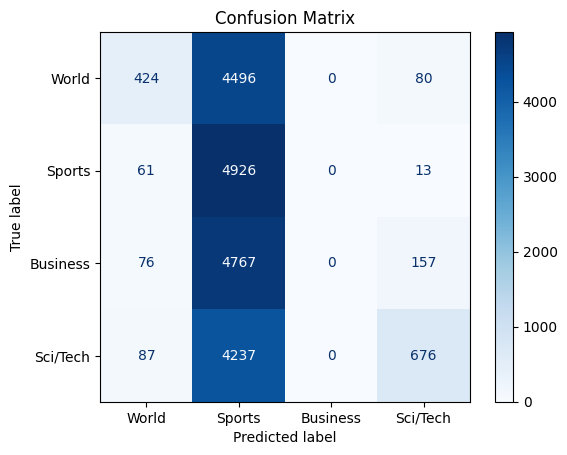

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.08      0.15      5000
           1       0.27      0.99      0.42      5000
           2       0.00      0.00      0.00      5000
           3       0.73      0.14      0.23      5000

    accuracy                           0.30     20000
   macro avg       0.41      0.30      0.20     20000
weighted avg       0.41      0.30      0.20     20000



c:\Users\mitsa\Desktop\Machine_Learning_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mitsa\Desktop\Machine_Learning_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mitsa\Desktop\Machine_Learning_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [99]:
kmeans_train_predictions = kmeans.predict(X_train_scaled)
plot_confusion_matrix(y_train_sampled, kmeans_train_predictions)
plot_classification_report(y_train_sampled, kmeans_train_predictions)

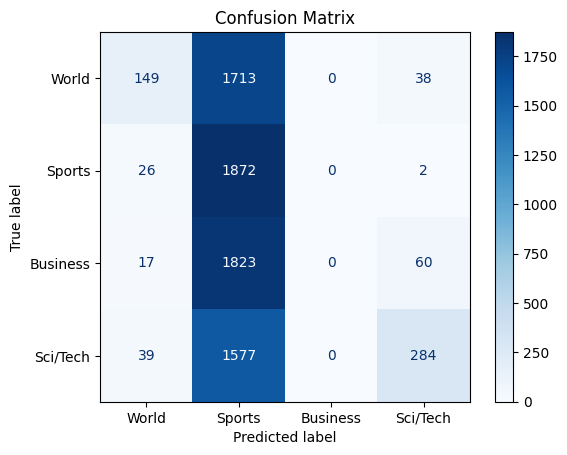

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.08      0.14      1900
           1       0.27      0.99      0.42      1900
           2       0.00      0.00      0.00      1900
           3       0.74      0.15      0.25      1900

    accuracy                           0.30      7600
   macro avg       0.41      0.30      0.20      7600
weighted avg       0.41      0.30      0.20      7600



c:\Users\mitsa\Desktop\Machine_Learning_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mitsa\Desktop\Machine_Learning_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mitsa\Desktop\Machine_Learning_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [100]:
kmeans_test_predictions = kmeans.predict(X_test_scaled)
plot_confusion_matrix(y_test, kmeans_test_predictions)
plot_classification_report(y_test, kmeans_test_predictions)

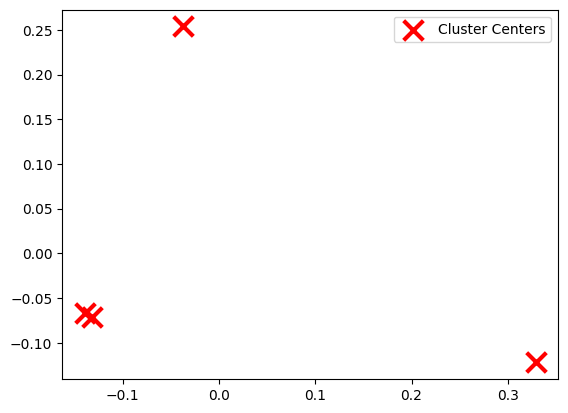

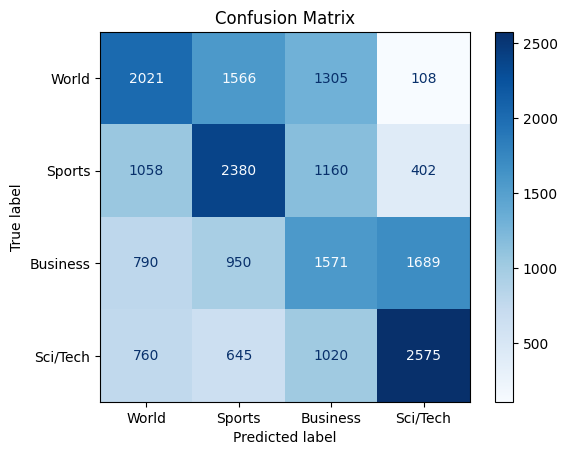

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.40      0.42      5000
           1       0.43      0.48      0.45      5000
           2       0.31      0.31      0.31      5000
           3       0.54      0.52      0.53      5000

    accuracy                           0.43     20000
   macro avg       0.43      0.43      0.43     20000
weighted avg       0.43      0.43      0.43     20000



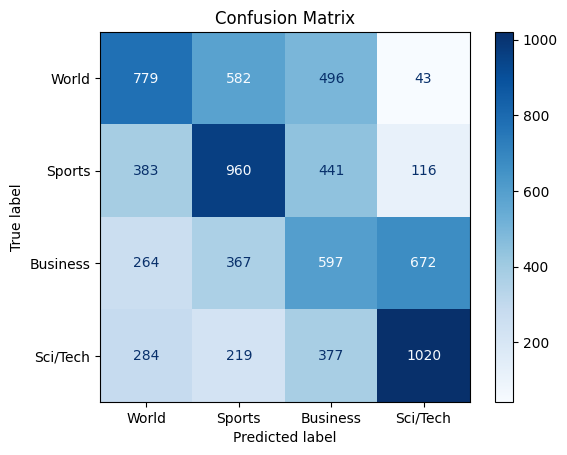

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.41      0.43      1900
           1       0.45      0.51      0.48      1900
           2       0.31      0.31      0.31      1900
           3       0.55      0.54      0.54      1900

    accuracy                           0.44      7600
   macro avg       0.44      0.44      0.44      7600
weighted avg       0.44      0.44      0.44      7600



In [101]:
kmeans = KMeansClassifier(n_clusters=4, random_state=42, distance_metric='cosine')
kmeans.fit(X_train_scaled, y_train_sampled)
centers = kmeans.centroids
labels = kmeans.cluster_labels

# Plot cluster centers with labels
plt.scatter(centers[:, 0], centers[:, 1], marker='x', s=200, linewidths=3, color='r', label='Cluster Centers')
plt.legend()
plt.show()

kmeans_train_predictions = kmeans.predict(X_train_scaled)
plot_confusion_matrix(y_train_sampled, kmeans_train_predictions)
plot_classification_report(y_train_sampled, kmeans_train_predictions)

kmeans_test_predictions = kmeans.predict(X_test_scaled)
plot_confusion_matrix(y_test, kmeans_test_predictions)
plot_classification_report(y_test, kmeans_test_predictions)

#### Sci-kit Learn Implementation

In [102]:
from sklearn.cluster import KMeans

# Initialize KMeans with 4 clusters
kmeans_2 = KMeans(n_clusters=4, random_state=42)

# Fit the model to the reduced data
kmeans_train_predictions_2 = kmeans_2.fit_predict(X_train_scaled)

# Get cluster labels
labels = kmeans_2.labels_

# Get cluster centers
centers = kmeans_2.cluster_centers_

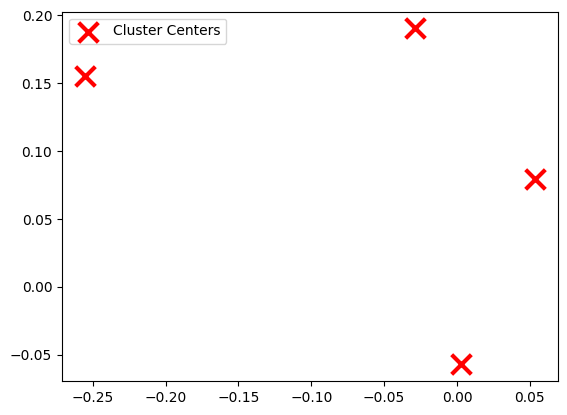

In [103]:
# Plot cluster centers with labels
plt.scatter(centers[:, 0], centers[:, 1], marker='x', s=200, linewidths=3, color='r', label='Cluster Centers')
plt.legend()
plt.show()

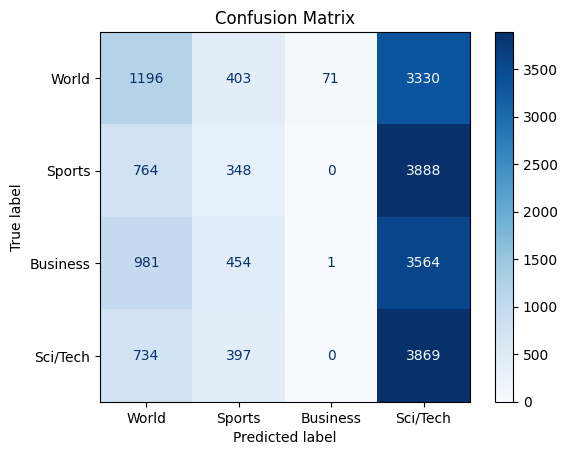

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.24      0.28      5000
           1       0.22      0.07      0.11      5000
           2       0.01      0.00      0.00      5000
           3       0.26      0.77      0.39      5000

    accuracy                           0.27     20000
   macro avg       0.21      0.27      0.19     20000
weighted avg       0.21      0.27      0.19     20000



In [104]:
plot_confusion_matrix(y_train_sampled, kmeans_train_predictions_2)
plot_classification_report(y_train_sampled, kmeans_train_predictions_2)

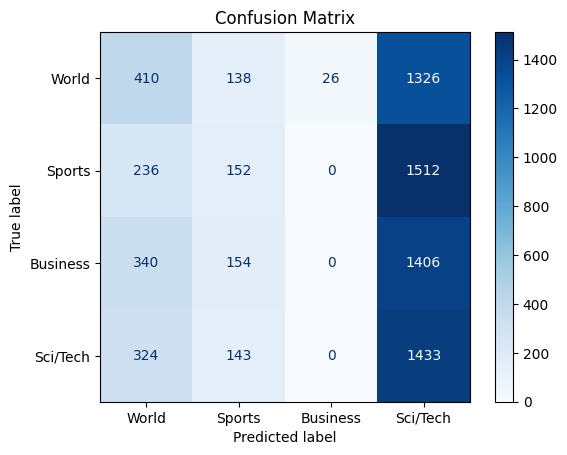

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.22      0.26      1900
           1       0.26      0.08      0.12      1900
           2       0.00      0.00      0.00      1900
           3       0.25      0.75      0.38      1900

    accuracy                           0.26      7600
   macro avg       0.21      0.26      0.19      7600
weighted avg       0.21      0.26      0.19      7600



In [105]:
kmeans_test_predictions_2 = kmeans_2.predict(X_test_scaled)
plot_confusion_matrix(y_test, kmeans_test_predictions_2)
plot_classification_report(y_test, kmeans_test_predictions_2)